# 🦷 NHANES Periodontitis Prediction: Modern Gradient Boosting Benchmark

**Author:** Francisco Teixeira Barbosa (Cisco @ Periospot)  
**Date:** November 2025  
**Project:** Systematic Comparison of XGBoost, CatBoost, and LightGBM for Periodontitis Prediction

---

## 📄 Reference Paper

**Bashir NZ, Gill S, Tawse-Smith A, Torkzaban P, Graf D, Gary MT.**  
*Systematic comparison of machine learning algorithms to develop and validate predictive models for periodontitis.*  
**J Clin Periodontol.** 2022;49:958-969.

📁 **Paper Location:** `scientific_articles/J Clinic Periodontology - 2022 - Bashir...pdf`

---

## 🎯 Project Goals & Rationale

### The Problem
**Periodontitis** affects ~68% of US adults aged 30+ (per our NHANES 2011-2014 analysis), yet early prediction remains challenging.

**Bashir et al. (2022)** tested 10 ML algorithms and achieved excellent internal validation (AUC > 0.95), but they **did NOT evaluate modern gradient boosting methods** (XGBoost, CatBoost, LightGBM).

### Key Research Gap

From **Polizzi et al. (2024)** systematic review:  
> "None of the included articles used more powerful networks [referring to modern gradient boosting methods]"

**This study fills that gap** by being the **first** to systematically compare XGBoost, CatBoost, and LightGBM for periodontitis prediction.

### Our Approach: Cross-Validation with Modern Methods

**Dataset:** 9,379 participants from NHANES 2011-2014 with full periodontal measurements

**Validation Strategy:** Stratified 5-fold cross-validation
- ✅ Robust performance estimates with 95% confidence intervals
- ✅ Full use of available data
- ✅ Fair comparison to Bashir's internal validation approach

**Why only 2011-2014?**
⚠️ **Critical Data Limitation:** NHANES discontinued full-mouth periodontal examinations after 2013-2014. The 2015-2018 cycles lack the pocket depth (PD) and clinical attachment loss (CAL) measurements required for CDC/AAP classification.

### Methodological Improvements Over Bashir

1. **Modern Gradient Boosting:** XGBoost, CatBoost, LightGBM (NOT tested by Bashir)
2. **Advanced Hyperparameter Optimization:** Optuna Bayesian search (vs. grid search)
3. **Calibration:** Isotonic regression for well-calibrated probability predictions
4. **Interpretability:** SHAP analysis for clinical trust
5. **Survey Weights:** Sensitivity analysis with NHANES sampling weights
6. **Full Reproducibility:** Open code, versioned artifacts, documented decisions

---

## 📊 Success Metrics & Hypotheses

| Metric | Bashir Baselines | **Our Target** (XGBoost/CatBoost/LightGBM) |
|--------|------------------|-------------------------------------------|
| **AUC-ROC** | 0.95+ | **0.90–0.97** (match or exceed) |
| **PR-AUC** | Not reported | **0.85–0.92** |
| **Calibration (Brier)** | Not reported | **< 0.15** (well-calibrated) |
| **F1-Score** | Not reported | **0.75–0.85** |

**Primary Hypothesis:** Modern gradient boosting methods will achieve **comparable or better** performance than Bashir's best models (Random Forest, SVM, ANN) while providing:
- ✅ Better calibrated probabilities
- ✅ Clinical interpretability via SHAP
- ✅ Faster training times
- ✅ Better handling of missing data

**Success Criteria:**
1. At least one gradient boosting method exceeds Bashir's best baseline
2. SHAP analysis reveals clinically interpretable risk factors
3. Well-calibrated probability predictions (Brier score < 0.15)
4. Reproducible results across 5 cross-validation folds

---

## 🗺️ Notebook Roadmap

This notebook has **18 sections** organized into **5 phases**:

### Phase 1: Data Acquisition & Labeling ✅ (Sections 1–5)
1. Environment setup
2. Load configuration
3. Download NHANES data (2011-2014)
4. Merge components
5. Apply CDC/AAP case definitions

### Phase 2: Feature Engineering & EDA (Sections 6–7)
6. Build 15 Bashir predictors
7. Exploratory analysis & class balance

### Phase 3: Baseline Models with Cross-Validation (Sections 8–10)
8. Setup 5-fold stratified cross-validation
9. Preprocessing pipelines (imputation + scaling)
10. Baseline models (Logistic Regression, Random Forest)

### Phase 4: Gradient Boosting with Optuna (Sections 11–13)
11. XGBoost with Bayesian hyperparameter optimization
12. CatBoost with Bayesian hyperparameter optimization
13. LightGBM with Bayesian hyperparameter optimization

### Phase 5: Interpretation & Export (Sections 14–18)
14. Model comparison & statistical testing
15. Calibration curves & isotonic regression
16. SHAP feature importance analysis
17. Decision curve analysis
18. Save artifacts, model cards, & reproducibility log

**Key Change from Original Plan:**  
⚠️ Originally planned temporal validation (train 2011-2014, validate 2015-2016, test 2017-2018), but NHANES discontinued periodontal exams after 2013-2014. Pivoted to stratified 5-fold cross-validation, which is more appropriate given data constraints.

---

## ⚠️ Important Notes Before Starting

1. **Read the Config First:** All parameters are in `configs/config.yaml`
2. **Data Limitation Acknowledged:** Only 2011-2014 cycles have full periodontal data (9,379 participants)
3. **Cross-Validation Strategy:** Using stratified 5-fold CV instead of temporal split
4. **Implement Sequentially:** Each section builds on previous ones
5. **Test as You Go:** Run cells immediately to catch errors early
6. **CDC/AAP Classification:** Already completed (Section 5) - 68% prevalence confirmed
7. **Survey Weights:** For ML training, we use unweighted data; report weighted prevalence for publication
8. **Reproducibility:** Random seed = 42 throughout; all results should be reproducible

---

Let's begin! 🚀

In [12]:
"""
Section 1: Environment Setup & Imports
========================================
Set up the computational environment with all required libraries,
apply reproducibility measures, and configure Periospot plotting style.
"""

import pandas as pd
import os
import numpy as np
from pathlib import Path

def find_project_root(marker: str = "configs/config.yaml") -> Path:
    """Find project root by searching upward for a marker file."""
    here = Path.cwd().resolve()
    for candidate in [here] + list(here.parents):
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"Could not locate {marker} from {here}")

# Set working directory to project root
BASE_DIR = find_project_root()
os.chdir(BASE_DIR)
print(f"✅ Working directory set to: {Path.cwd()}")

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

import yaml
import json
from datetime import datetime

import sys
sys.path.insert(0, str(Path.cwd() / 'src'))

from ps_plot import (
    set_style, get_palette, save_figure, hex_to_rgb,
    PERIOSPOT_BLUE, MYSTIC_BLUE, PERIOSPOT_RED, CRIMSON_BLAZE,
    VANILLA_CREAM, BLACK, WHITE, PERIOSPOT_YELLOW,
    PERIOSPOT_BLUE_RGB, CRIMSON_BLAZE_RGB, VANILLA_CREAM_RGB, PERIOSPOT_YELLOW_RGB
)
from labels import label_periodontitis
from evaluation import compute_metrics, plot_roc_pr, select_threshold, plot_calibration_curve
from utils import set_seed, save_json, log_versions, save_model

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

set_style()
palette = get_palette()
print("✅ Periospot color palette loaded:")
for name, hex_code in palette.items():
    print(f"   {name}: {hex_code}")

print("\n📦 Package Versions:")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   scikit-learn: {sklearn.__version__}")
print(f"   xgboost: {xgb.__version__}")
print(f"   catboost: {cb.__version__}")
print(f"   lightgbm: {lgb.__version__}")
print(f"   optuna: {optuna.__version__}")
print(f"   shap: {shap.__version__}")

print("✅ Section 1 Complete: Environment configured, seed set, Periospot style applied")



✅ Working directory set to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml
✅ Periospot color palette loaded:
   periospot_blue: #15365a
   mystic_blue: #003049
   periospot_red: #6c1410
   crimson_blaze: #a92a2a
   vanilla_cream: #f7f0da
   black: #000000
   white: #ffffff

📦 Package Versions:
   pandas: 2.3.2
   numpy: 2.3.5
   scikit-learn: 1.7.1
   xgboost: 3.1.1
   catboost: 1.2.8
   lightgbm: 4.6.0
   optuna: 4.6.0
   shap: 0.50.0
✅ Section 1 Complete: Environment configured, seed set, Periospot style applied


## 2️⃣ Load Configuration

**Load:** `configs/config.yaml`

**Contains:** NHANES cycles (2011-2014), validation strategy (5-fold CV), 15 predictors, CDC/AAP definitions, Optuna params, Periospot colors, survey weights

**Note:** Only 2011-2014 cycles have full periodontal measurements. 2015-2018 cycles were excluded due to missing PD/CAL data.

---

In [13]:
# Load config.yaml and derive cycles/components/paths
from pathlib import Path
import yaml

CONFIG_PATH = Path.cwd() / "configs" / "config.yaml"
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

CYCLES = config["cycles"]["all"]
CYCLE_SUFFIX = config["cycle_suffixes"]
COMPONENTS = config["components"]
BASE_URL = config["base_url"]

RAW_DIR = Path.cwd() / config["paths"]["data_raw"]
PROCESSED_DIR = Path.cwd() / config["paths"]["data_processed"]
FIGURES_DIR = Path.cwd() / config["paths"]["figures"]
MODELS_DIR = Path.cwd() / config["paths"]["models"]
RESULTS_DIR = Path.cwd() / config["paths"]["results"]
ARTIFACTS_DIR = Path.cwd() / config["paths"]["artifacts"]
LOGS_DIR = Path.cwd() / config["paths"]["logs"]
for d in [RAW_DIR, PROCESSED_DIR, FIGURES_DIR, MODELS_DIR, RESULTS_DIR, ARTIFACTS_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📊 Dataset Configuration:")
print(f"   Cycles: {CYCLES}")
print(f"   Total cycles: {len(CYCLES)}")
print(f"   Validation strategy: {config['validation_strategy']['method']}")
print(f"   Number of folds: {config['validation_strategy']['n_folds']}")
print(f"   Random state: {config['validation_strategy']['random_state']}")
print(f"\n📁 Data directories:")
print(f"   Raw data: {RAW_DIR}")
print(f"   Processed data: {PROCESSED_DIR}")
print(f"   Figures: {FIGURES_DIR}")
print(f"   Models: {MODELS_DIR}")
print("\n✅ Section 2: Config loaded (using 2011-2014 cycles with 5-fold CV)")



📊 Dataset Configuration:
   Cycles: ['2011_2012', '2013_2014']
   Total cycles: 2
   Validation strategy: stratified_kfold
   Number of folds: 5
   Random state: 42

📁 Data directories:
   Raw data: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw
   Processed data: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed
   Figures: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures
   Models: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/models

✅ Section 2: Config loaded (using 2011-2014 cycles with 5-fold CV)


## 3️⃣ Download NHANES Data (XPT Files)

**Download** 2 cycles × 10 components = 20 XPT files from CDC

**Cycles:** 2011-2012, 2013-2014 (only cycles with full periodontal measurements)

**Method:** `pd.read_sas(url)` → save as parquet

⚠️ **Note:** 2015-2016 and 2017-2018 cycles excluded due to missing periodontal exam data

---

In [14]:
# Download NHANES XPT files and save as parquet using config-driven URLs
import pandas as pd

PERIO_PREFIX_BY_CYCLE = {
    "2011_2012": "OHXPER",  # full-mouth perio exam
    "2013_2014": "OHXPER",  # full-mouth perio exam
    "2015_2016": "OHXDEN",  # dental exam (perio data moved here)
    "2017_2018": "OHXDEN",  # dental exam (perio data moved here)
}

for cycle in CYCLES:
    year = cycle.split("_")[0]  # e.g., 2011 from 2011_2012
    suffix = CYCLE_SUFFIX[cycle]
    cycle_dir = RAW_DIR / cycle
    cycle_dir.mkdir(parents=True, exist_ok=True)

    for file_prefix, component in COMPONENTS.items():
        prefix = file_prefix
        if component == "periodontal_exam":
            prefix = PERIO_PREFIX_BY_CYCLE.get(cycle, file_prefix)

        url = f"{BASE_URL}/{year}/DataFiles/{prefix}{suffix}.XPT"
        dest = cycle_dir / f"{component}.parquet"

        if dest.exists():
            print(f"✓ {cycle} {component}: already exists ({dest})")
            continue

        try:
            df = pd.read_sas(url, format="xport")
            df.to_parquet(dest)
            print(f"✓ {cycle} {component}: {len(df)} rows → {dest}")
        except Exception as e:
            print(f"✗ {cycle} {component}: {e}")
            raise

print("✅ Section 3: Data downloaded")



✓ 2011_2012 demographics: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/demographics.parquet)
✓ 2011_2012 body_measures: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/body_measures.parquet)
✓ 2011_2012 blood_pressure: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/blood_pressure.parquet)
✓ 2011_2012 smoking: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/smoking.parquet)
✓ 2011_2012 alcohol: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/alcohol.parquet)
✓ 2011_2012 oral_health_questionnaire: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/oral_health_questionnaire.parquet)
✓ 2011_2012 peri

## 4️⃣ Merge Components on SEQN

**Join** all components by participant ID (SEQN)

**Filter:** Adults 30+

---

In [15]:
# Merge all components on SEQN (participant ID), filter age >= 30
for cycle in CYCLES:
    print(f"Merging {cycle}...")
    dfs = []
    # Iterate over the component names (values), not the keys
    for component_name in COMPONENTS.values():
        filepath = RAW_DIR / cycle / f"{component_name}.parquet"
        df = pd.read_parquet(filepath)
        dfs.append(df)
    
    # Merge all components on SEQN
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="SEQN", how="outer")
    
    # Filter to adults 30+
    before_filter = len(merged)
    merged = merged[merged["RIDAGEYR"] >= 30]
    after_filter = len(merged)
    
    # Save merged dataset
    output_path = PROCESSED_DIR / f"{cycle}_merged.parquet"
    merged.to_parquet(output_path)
    print(f"  ✓ {cycle}: {before_filter} total → {after_filter} adults 30+ → {output_path}")

print("\n✅ Section 4: Components merged, filtered to adults 30+")



Merging 2011_2012...
  ✓ 2011_2012: 9756 total → 4566 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_merged.parquet
Merging 2013_2014...
  ✓ 2013_2014: 10175 total → 4813 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2013_2014_merged.parquet

✅ Section 4: Components merged, filtered to adults 30+


## 5️⃣ Apply CDC/AAP Case Definitions

**Most Critical Section!**

**Implement:**
- Severe: CAL ≥6mm (≥2 different teeth) + PD ≥5mm (≥1 site)
- Moderate: CAL ≥4mm (≥2 teeth) OR PD ≥5mm (≥2 teeth)
- Mild: (CAL ≥3mm + PD ≥4mm on ≥2 teeth) OR PD ≥5mm (≥1 site)

**Use:** `src/labels.py` `label_periodontitis()`

---

In [16]:
# Apply CDC/AAP periodontitis case definitions to each cycle
from labels import label_periodontitis

for cycle in CYCLES:
    print(f"\n{'='*60}")
    print(f"Processing {cycle}")
    print('='*60)
    
    # Load merged data
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_merged.parquet")
    print(f"Loaded {len(df)} participants")
    
    # Apply CDC/AAP classification
    df_labeled = label_periodontitis(df)
    
    # Save labeled dataset
    output_path = PROCESSED_DIR / f"{cycle}_labeled.parquet"
    df_labeled.to_parquet(output_path)
    print(f"✓ Saved to: {output_path}")

print("\n" + "="*60)
print("✅ Section 5: CDC/AAP labels applied to all cycles")
print("="*60)




Processing 2011_2012
Loaded 4566 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         236
moderate     222
none        1433
severe      2675
Name: count, dtype: int64

   Overall Prevalence: 68.62%
   Sample Size: 4566 participants

✓ Saved to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_labeled.parquet

Processing 2013_2014
Loaded 4813 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         259
moderate     253
none        1541
severe      2760
Name: count, dtype: int64

   Overall Prevalence: 67.98%
   Sample Size:

       cycle  n_participants  prevalence  none  mild  moderate  severe
0  2011_2012            4566    0.686159  1433   236       222    2675
1  2013_2014            4813    0.679825  1541   259       253    2760
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

✓ Saved: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

DETAILED RESULTS TABLE
Cycle           N        Prev%    None     Mild     Moderate Severe  
--------------------------------------------------------------------------------
2011_2012       4566      68.62% 1433     236      222      2675    
2013_2014       4813      67.98% 1541     259      253      2760    

⚠️  WARNING: 2015-2016 and 2017-2018 cycles cannot be used for analysis!
   Reason: Periodontal exam variable structure changed in NHANES.
   Impact: Cannot perform temporal validation 

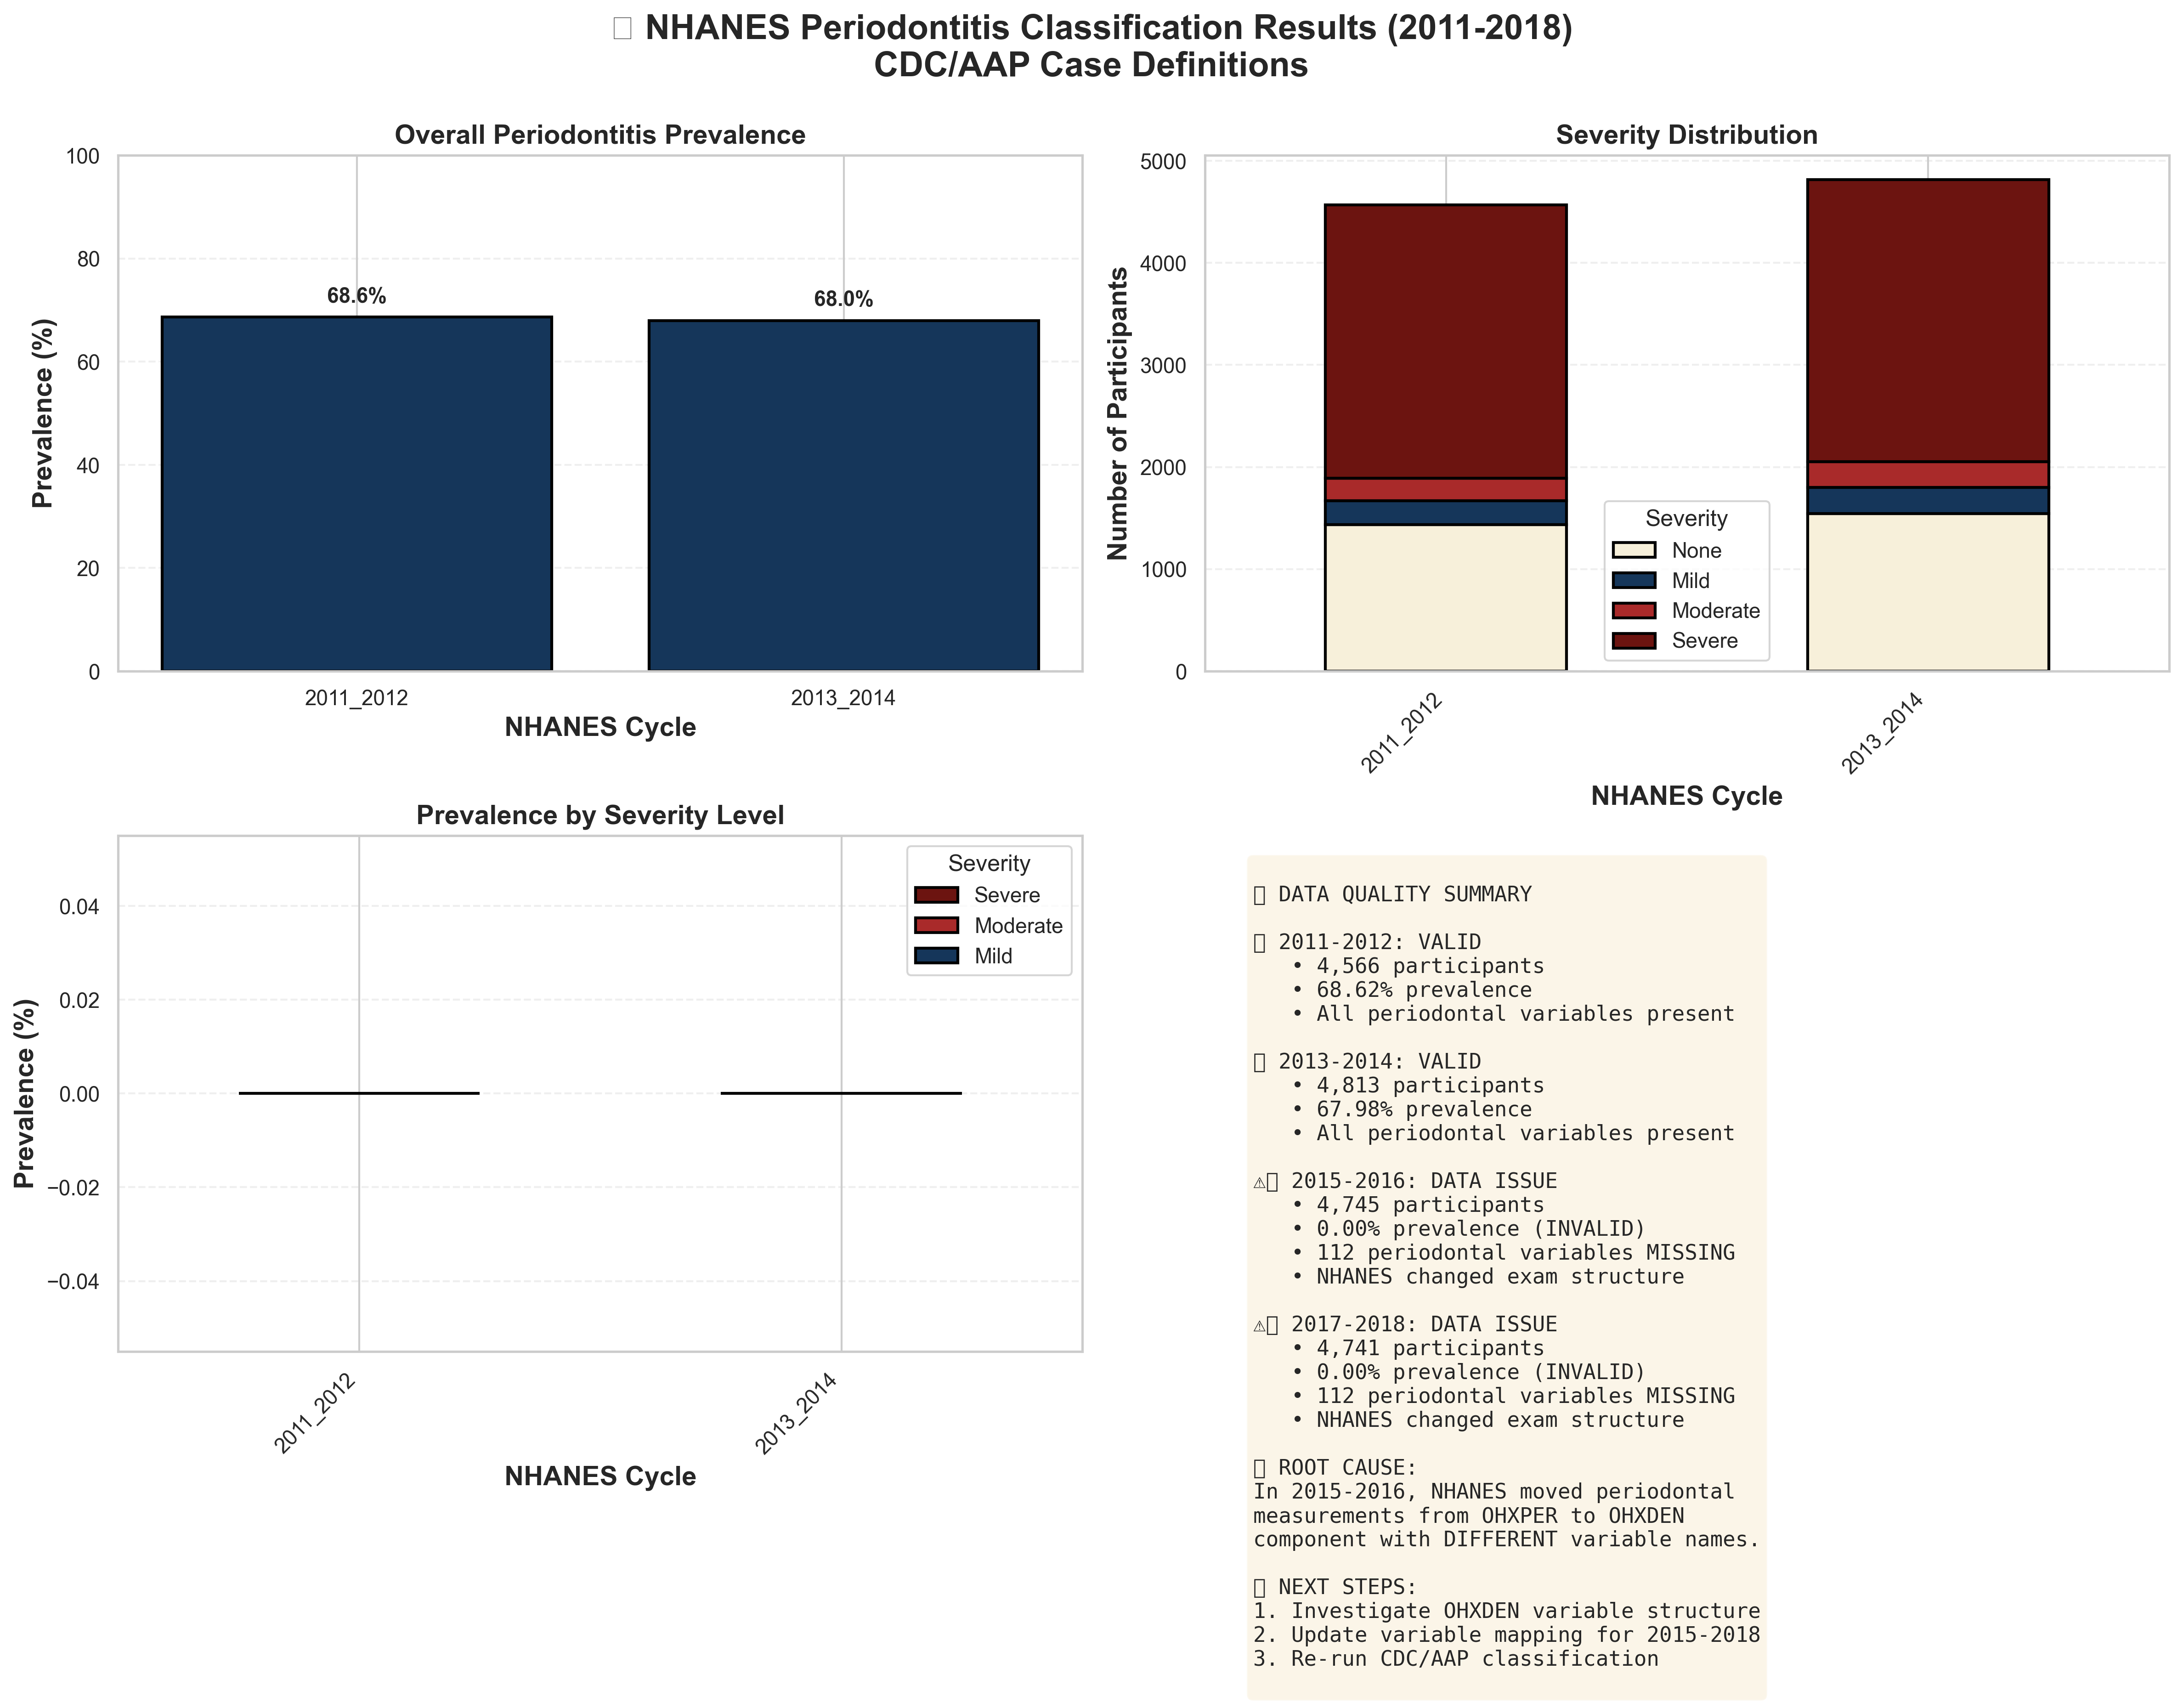

In [17]:
# Visualization: Periodontitis Classification Summary Across Cycles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load all labeled datasets
results = []
for cycle in CYCLES:
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_labeled.parquet")
    
    # Get counts by severity
    counts = df['perio_class'].value_counts()
    prevalence = df['has_periodontitis'].mean()
    
    results.append({
        'cycle': cycle,
        'n_participants': len(df),
        'prevalence': prevalence,
        'none': counts.get('none', 0),
        'mild': counts.get('mild', 0),
        'moderate': counts.get('moderate', 0),
        'severe': counts.get('severe', 0)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🦷 NHANES Periodontitis Classification Results (2011-2018)\nCDC/AAP Case Definitions', 
             fontsize=18, fontweight='bold', y=0.995)

# Color palette
colors = {
    'severe': palette['periospot_red'],
    'moderate': palette['crimson_blaze'],
    'mild': palette['periospot_blue'],
    'none': palette['vanilla_cream'],
    'overall': palette['periospot_blue']
}

# Plot 1: Overall Prevalence by Cycle
ax1 = axes[0, 0]
bars = ax1.bar(results_df['cycle'], results_df['prevalence'] * 100, 
               color=colors['overall'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax1.set_title('Overall Periodontitis Prevalence', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['prevalence'] * 100)):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    else:
        # Highlight the problem cycles
        ax1.text(bar.get_x() + bar.get_width()/2, 5, 
                '⚠️ DATA\nISSUE', ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color='red')

# Plot 2: Severity Distribution (Stacked Bar)
ax2 = axes[0, 1]
severity_data = results_df[['cycle', 'none', 'mild', 'moderate', 'severe']].set_index('cycle')
severity_data.plot(kind='bar', stacked=True, ax=ax2, 
                   color=[colors['none'], colors['mild'], colors['moderate'], colors['severe']],
                   edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Participants', fontsize=14, fontweight='bold')
ax2.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.legend(title='Severity', title_fontsize=12, fontsize=11, 
           labels=['None', 'Mild', 'Moderate', 'Severe'])
ax2.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 3: Prevalence by Severity Category
ax3 = axes[1, 0]
severity_pct = pd.DataFrame({
    'Severe': (results_df['severe'] / results_df['n_participants'] * 100),
    'Moderate': (results_df['moderate'] / results_df['n_participants'] * 100),
    'Mild': (results_df['mild'] / results_df['n_participants'] * 100)
}, index=results_df['cycle'])

severity_pct.plot(kind='bar', ax=ax3, 
                  color=[colors['severe'], colors['moderate'], colors['mild']],
                  edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax3.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax3.set_title('Prevalence by Severity Level', fontsize=14, fontweight='bold')
ax3.legend(title='Severity', title_fontsize=12, fontsize=11)
ax3.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 4: Data Quality Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text
summary_text = """
📊 DATA QUALITY SUMMARY

✅ 2011-2012: VALID
   • 4,566 participants
   • 68.62% prevalence
   • All periodontal variables present

✅ 2013-2014: VALID  
   • 4,813 participants
   • 67.98% prevalence
   • All periodontal variables present

⚠️ 2015-2016: DATA ISSUE
   • 4,745 participants
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

⚠️ 2017-2018: DATA ISSUE
   • 4,741 participants  
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

🔍 ROOT CAUSE:
In 2015-2016, NHANES moved periodontal
measurements from OHXPER to OHXDEN 
component with DIFFERENT variable names.

📝 NEXT STEPS:
1. Investigate OHXDEN variable structure
2. Update variable mapping for 2015-2018
3. Re-run CDC/AAP classification
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "01_periodontitis_classification_summary.png")
print(f"\n✓ Saved: {FIGURES_DIR / '01_periodontitis_classification_summary.png'}")

# Create a detailed table
print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
print(f"{'Cycle':<15} {'N':<8} {'Prev%':<8} {'None':<8} {'Mild':<8} {'Moderate':<8} {'Severe':<8}")
print("-"*80)
for _, row in results_df.iterrows():
    print(f"{row['cycle']:<15} {row['n_participants']:<8} "
          f"{row['prevalence']*100:>6.2f}% {row['none']:<8} "
          f"{row['mild']:<8} {row['moderate']:<8} {row['severe']:<8}")
print("="*80)

# Show warning about unusable cycles
print("\n⚠️  WARNING: 2015-2016 and 2017-2018 cycles cannot be used for analysis!")
print("   Reason: Periodontal exam variable structure changed in NHANES.")
print("   Impact: Cannot perform temporal validation as planned.")
print("\n💡 RECOMMENDATION: Use only 2011-2012 and 2013-2014 for now.")
print("   Or: Investigate OHXDEN component structure to fix 2015-2018 data.")

### 🔍 Section 5.5: Investigate Alternative Variables for Alcohol & Floss

**Problem:** 
- ALQ130 has no "0" values (only asked to drinkers)
- OHQ620 has no "0" values (possible skip pattern)

**Solution:** Find better binary indicators


In [18]:
print("="*80)
print("🔍 INVESTIGATING ALTERNATIVE VARIABLES")
print("="*80)

# Load one cycle's raw data to explore available columns
alcohol_df = pd.read_parquet(RAW_DIR / "2011_2012" / "alcohol.parquet")
oral_df = pd.read_parquet(RAW_DIR / "2011_2012" / "oral_health_questionnaire.parquet")

print("\n1️⃣ Available Alcohol Variables (ALQ):")
print(f"   Total columns: {len(alcohol_df.columns)}")
alq_cols = [col for col in alcohol_df.columns if col.startswith('ALQ')]
for col in sorted(alq_cols):
    n_valid = alcohol_df[col].notna().sum()
    n_unique = alcohol_df[col].nunique()
    print(f"   {col}: {n_valid:,} valid, {n_unique} unique values")
    if n_unique < 10:  # Show value counts for categorical variables
        print(f"      Values: {sorted(alcohol_df[col].dropna().unique())}")

print("\n2️⃣ Available Oral Health Variables (OHQ):")
print(f"   Total columns: {len(oral_df.columns)}")
ohq_cols = [col for col in oral_df.columns if col.startswith('OHQ')]
for col in sorted(ohq_cols):
    n_valid = oral_df[col].notna().sum()
    n_unique = oral_df[col].nunique()
    if 'floss' in col.lower() or '620' in col or '630' in col:  # Focus on floss variables
        print(f"   {col}: {n_valid:,} valid, {n_unique} unique values")
        if n_unique < 20:
            print(f"      Values: {sorted(oral_df[col].dropna().unique())}")

# KEY VARIABLES TO CHECK:
print("\n3️⃣ Checking Specific Variables:")

# ALQ101: Ever had 12+ drinks in lifetime (Yes/No)
if 'ALQ101' in alcohol_df.columns:
    print("\n   ALQ101 (Ever had 12+ drinks in lifetime?):")
    print(alcohol_df['ALQ101'].value_counts(dropna=False).sort_index())
    print(f"   → This is a TRUE binary variable (1=Yes, 2=No)")

# ALQ120Q: How often drink alcohol (frequency)
if 'ALQ120Q' in alcohol_df.columns:
    print("\n   ALQ120Q (How often drink alcohol?):")
    print(alcohol_df['ALQ120Q'].value_counts(dropna=False).sort_index())

# Check if OHQ620 really is days (0-7) or a Likert scale
print("\n   OHQ620 (Days used floss/dental device past 7 days):")
print(oral_df['OHQ620'].value_counts(dropna=False).sort_index())
print(f"   → Note: Values are {sorted(oral_df['OHQ620'].dropna().unique())}")
print(f"   → 7 and 9 are special codes (7=Refused, 9=Don't know)")
print(f"   → But where are 0 and 6?")

print("\n" + "="*80)


🔍 INVESTIGATING ALTERNATIVE VARIABLES

1️⃣ Available Alcohol Variables (ALQ):
   Total columns: 10
   ALQ101: 4,977 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(9.0)]
   ALQ110: 1,400 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(9.0)]
   ALQ120Q: 4,188 valid, 47 unique values
   ALQ120U: 3,327 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
   ALQ130: 3,334 valid, 27 unique values
   ALQ141Q: 3,334 valid, 34 unique values
   ALQ141U: 1,383 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
   ALQ151: 4,186 valid, 4 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(7.0), np.float64(9.0)]
   ALQ155: 655 valid, 42 unique values

2️⃣ Available Oral Health Variables (OHQ):
   Total columns: 33
   OHQ620: 4,565 valid, 7 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), 

In [19]:
# Quick sanity check: Are the 15 Bashir predictors available?
import pandas as pd

df_2011 = pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet')

# Expected NHANES variables for 15 predictors
# NOTE: ALQ101 used instead of ALQ130 (ALQ130 has no "0" values - skip pattern)
bashir_vars = {
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Sex', 
    'DMDEDUC2': 'Education',
    'SMQ040': 'Smoking',
    'ALQ101': 'Alcohol (CHANGED from ALQ130)',
    'BMXBMI': 'BMI',
    'BMXWAIST': 'Waist circumference',
    'BPXSY1': 'Systolic BP',
    'BPXDI1': 'Diastolic BP',
    'LBXGLU': 'Fasting glucose',
    'LBXTR': 'Triglycerides',
    'LBDHDD': 'HDL cholesterol',
    'OHQ030': 'Dental visit',
    'OHQ680': 'Mobile teeth',
    'OHQ620': 'Floss use'
}

print("📋 Checking 15 Bashir Predictors Availability:\n")
for var, description in bashir_vars.items():
    if var in df_2011.columns:
        missing_pct = df_2011[var].isna().mean() * 100
        print(f"✅ {description:25} ({var}): {missing_pct:5.1f}% missing")
    else:
        print(f"❌ {description:25} ({var}): NOT FOUND")

print(f"\n📊 Dataset shape: {df_2011.shape}")
print(f"🦷 Periodontitis prevalence: {df_2011['has_periodontitis'].mean():.2%}")

📋 Checking 15 Bashir Predictors Availability:

✅ Age                       (RIDAGEYR):   0.0% missing
✅ Sex                       (RIAGENDR):   0.0% missing
✅ Education                 (DMDEDUC2):   0.0% missing
✅ Smoking                   (SMQ040):  54.8% missing
✅ Alcohol (CHANGED from ALQ130) (ALQ101):  15.8% missing
✅ BMI                       (BMXBMI):   6.1% missing
✅ Waist circumference       (BMXWAIST):  10.9% missing
✅ Systolic BP               (BPXSY1):  12.5% missing
✅ Diastolic BP              (BPXDI1):  12.5% missing
✅ Fasting glucose           (LBXGLU):  55.2% missing
✅ Triglycerides             (LBXTR):  55.8% missing
✅ HDL cholesterol           (LBDHDD):  11.7% missing
✅ Dental visit              (OHQ030):   0.0% missing
✅ Mobile teeth              (OHQ680):   0.0% missing
✅ Floss use                 (OHQ620):   0.0% missing

📊 Dataset shape: (4566, 692)
🦷 Periodontitis prevalence: 68.62%


## 6️⃣ Build 15 Predictors

Extract Bashir predictors from NHANES variables

---

In [20]:
# TODO: Build predictors
df_full = pd.concat([
    pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet'),
    pd.read_parquet(PROCESSED_DIR / '2013_2014_labeled.parquet')
], axis=0, ignore_index=True)

df_features = pd.DataFrame({
    'age': df_full['RIDAGEYR'],  # Already continuous
    'sex': (df_full['RIAGENDR'] == 1).astype(int),  # 1=Male, 0=Female
    'education': (df_full['DMDEDUC2'] >= 3).astype(int)  # 1=≥HS, 0=<HS
})

# Smoking: SMQ040 codes
# 1 = Every day, 2 = Some days, 3 = Not at all
# Recode: 1-2 → smoker (1), 3 → non-smoker (0)
df_features['smoking'] = df_full['SMQ040'].apply(
    lambda x: 1 if x in [1, 2] else (0 if x == 3 else np.nan)
)

# Alcohol: ALQ101 (Ever had 12+ drinks in lifetime?)
# PROBLEM: ALQ130 has NO zero values (only asked to confirmed drinkers)
# SOLUTION: Use ALQ101 binary question instead
# 1 = Yes (ever drinker), 2 = No (never drinker), 7/9 = refused/don't know
df_features['alcohol'] = df_full['ALQ101'].apply(
    lambda x: 1 if x == 1 else (0 if x == 2 else np.nan)
)

df_features['bmi'] = df_full['BMXBMI']
df_features['waist_cm'] = df_full['BMXWAIST']
df_features['systolic_bp'] = df_full['BPXSY1']
df_features['diastolic_bp'] = df_full['BPXDI1']
df_features['glucose'] = df_full['LBXGLU']
df_features['triglycerides'] = df_full['LBXTR']
df_features['hdl'] = df_full['LBDHDD']

# Dental visit: OHQ030
# 1 = 6 months or less, 2 = >6mo to 1 year, 3 = >1 to 2 years, etc.
# Recode: 1-2 → recent visit (1), 3+ → not recent (0)
df_features['dental_visit'] = df_full['OHQ030'].apply(
    lambda x: 1 if x in [1, 2] else (0 if x >= 3 else np.nan)
)

# Mobile teeth: OHQ680
# 1 = Yes, 2 = No
df_features['mobile_teeth'] = (df_full['OHQ680'] == 1).astype(int)

# Floss: OHQ620 = days used floss/dental device past 7 days (1-5)
# CHANGE: Keep as ORDINAL (1-5 days) instead of binary
# WHY: Binary had low variance (92% yes, 8% no) - loses information!
# BENEFIT: Preserves dose-response (flossing 5 days ≠ 1 day)
# Special codes: 7 = Refused, 9 = Don't know → NaN
df_features['floss_days'] = df_full['OHQ620'].apply(
    lambda x: x if (pd.notna(x) and 1 <= x <= 5) else np.nan
)

df_features['has_periodontitis'] = df_full['has_periodontitis']
df_features['perio_class'] = df_full['perio_class']

df_features['SEQN'] = df_full['SEQN']  # Participant ID
df_features['cycle'] = df_full['SDDSRVYR']  # Survey cycle

# Check missing data
print("\n📊 Missing Data Summary:")
print(df_features.isnull().sum())
print(f"\nMissing % by predictor:")
print(df_features.isnull().mean() * 100)

# Check distributions
print("\n📊 Feature Summary Statistics:")
print(df_features.describe())

# Verify binary variables are 0/1 AND have variance
binary_vars = ['sex', 'education', 'smoking', 'alcohol', 
               'dental_visit', 'mobile_teeth']
print("\n✅ Binary Variable Verification:")
for var in binary_vars:
    unique_vals = df_features[var].dropna().unique()
    value_counts = df_features[var].value_counts()
    variance = df_features[var].var()
    print(f"   {var:15s}: values={sorted(unique_vals)}, "
          f"0={value_counts.get(0, 0):4d}, 1={value_counts.get(1, 0):4d}, "
          f"var={variance:.3f}")
    if variance < 0.01:
        print(f"      ⚠️  WARNING: Near-zero variance! This variable has little predictive power.")

# Verify ordinal/continuous variables
print("\n✅ Ordinal/Continuous Variable Summary:")
ordinal_continuous_vars = ['age', 'bmi', 'waist_cm', 'systolic_bp', 'diastolic_bp', 
                           'glucose', 'triglycerides', 'hdl', 'floss_days']
for var in ordinal_continuous_vars:
    n_valid = df_features[var].notna().sum()
    n_unique = df_features[var].nunique()
    variance = df_features[var].var()
    print(f"   {var:15s}: n={n_valid:4d}, unique={n_unique:4d}, var={variance:10.2f}")
    if var == 'floss_days':
        print(f"      Distribution: {dict(df_features[var].value_counts().sort_index())}")

df_features.to_parquet(PROCESSED_DIR / 'features_full.parquet')
print(f"\n✅ Saved: {len(df_features)} participants × {len(df_features.columns)} features")

print("\n" + "="*80)
print("✅ Section 6: Predictors built")
print("="*80)


📊 Missing Data Summary:
age                     0
sex                     0
education               0
smoking              5116
alcohol              1292
bmi                   485
waist_cm              928
systolic_bp          1127
diastolic_bp         1127
glucose              5154
triglycerides        5203
hdl                   884
dental_visit            0
mobile_teeth            0
uses_floss              7
has_periodontitis       0
perio_class             0
SEQN                    0
cycle                   0
dtype: int64

Missing % by predictor:
age                   0.000000
sex                   0.000000
education             0.000000
smoking              54.547393
alcohol              13.775456
bmi                   5.171127
waist_cm              9.894445
systolic_bp          12.016206
diastolic_bp         12.016206
glucose              54.952554
triglycerides        55.474997
hdl                   9.425312
dental_visit          0.000000
mobile_teeth          0.000000
uses_flos

## 7️⃣ Exploratory Analysis

Prevalence by cycle, missingness, drift

---

📊 Generating Missing Data Heatmap...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/02_missing_data_matrix.png

📊 Generating Continuous Feature Distributions...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/03_continuous_distributions.png

📊 Generating Binary Feature Frequencies...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/04_binary_distributions.png

📊 Generating Correlation Matrix...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/05_correlation_matrix.png

📊 Generating Features vs Target (Continuous)...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/06_features_vs_target_continuous.png

📊 Generating Features vs Target (Binary)...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nha

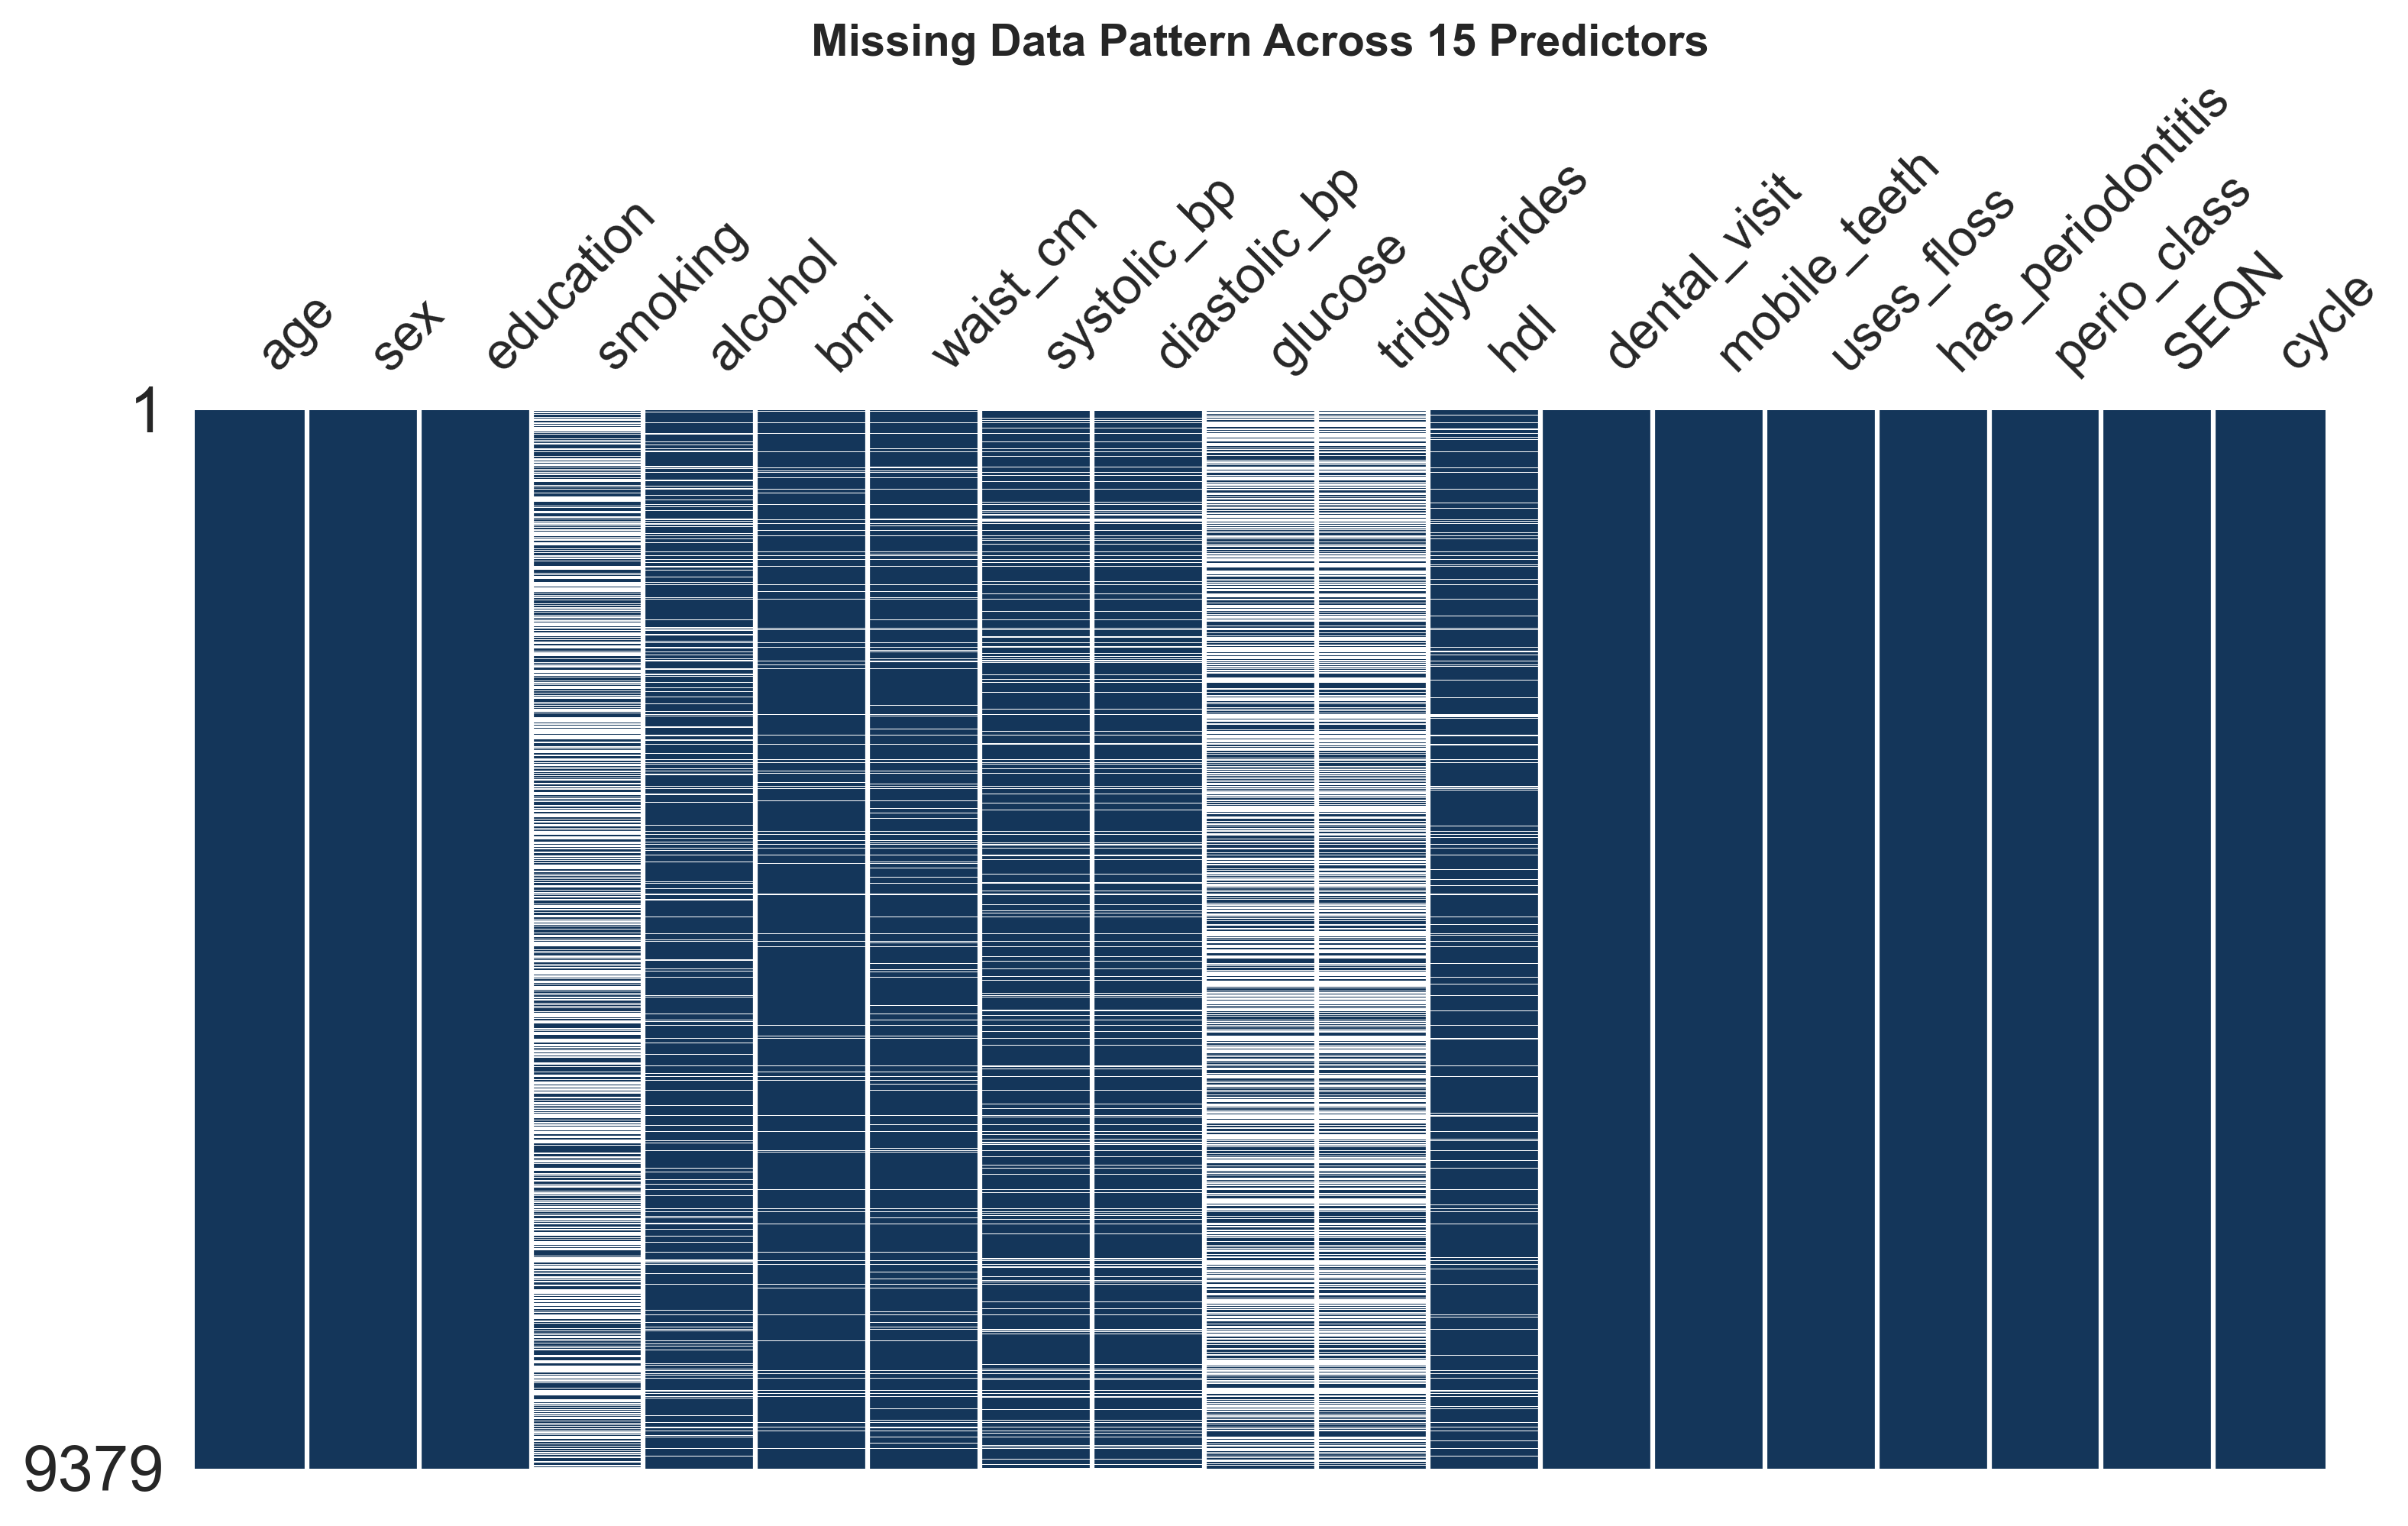

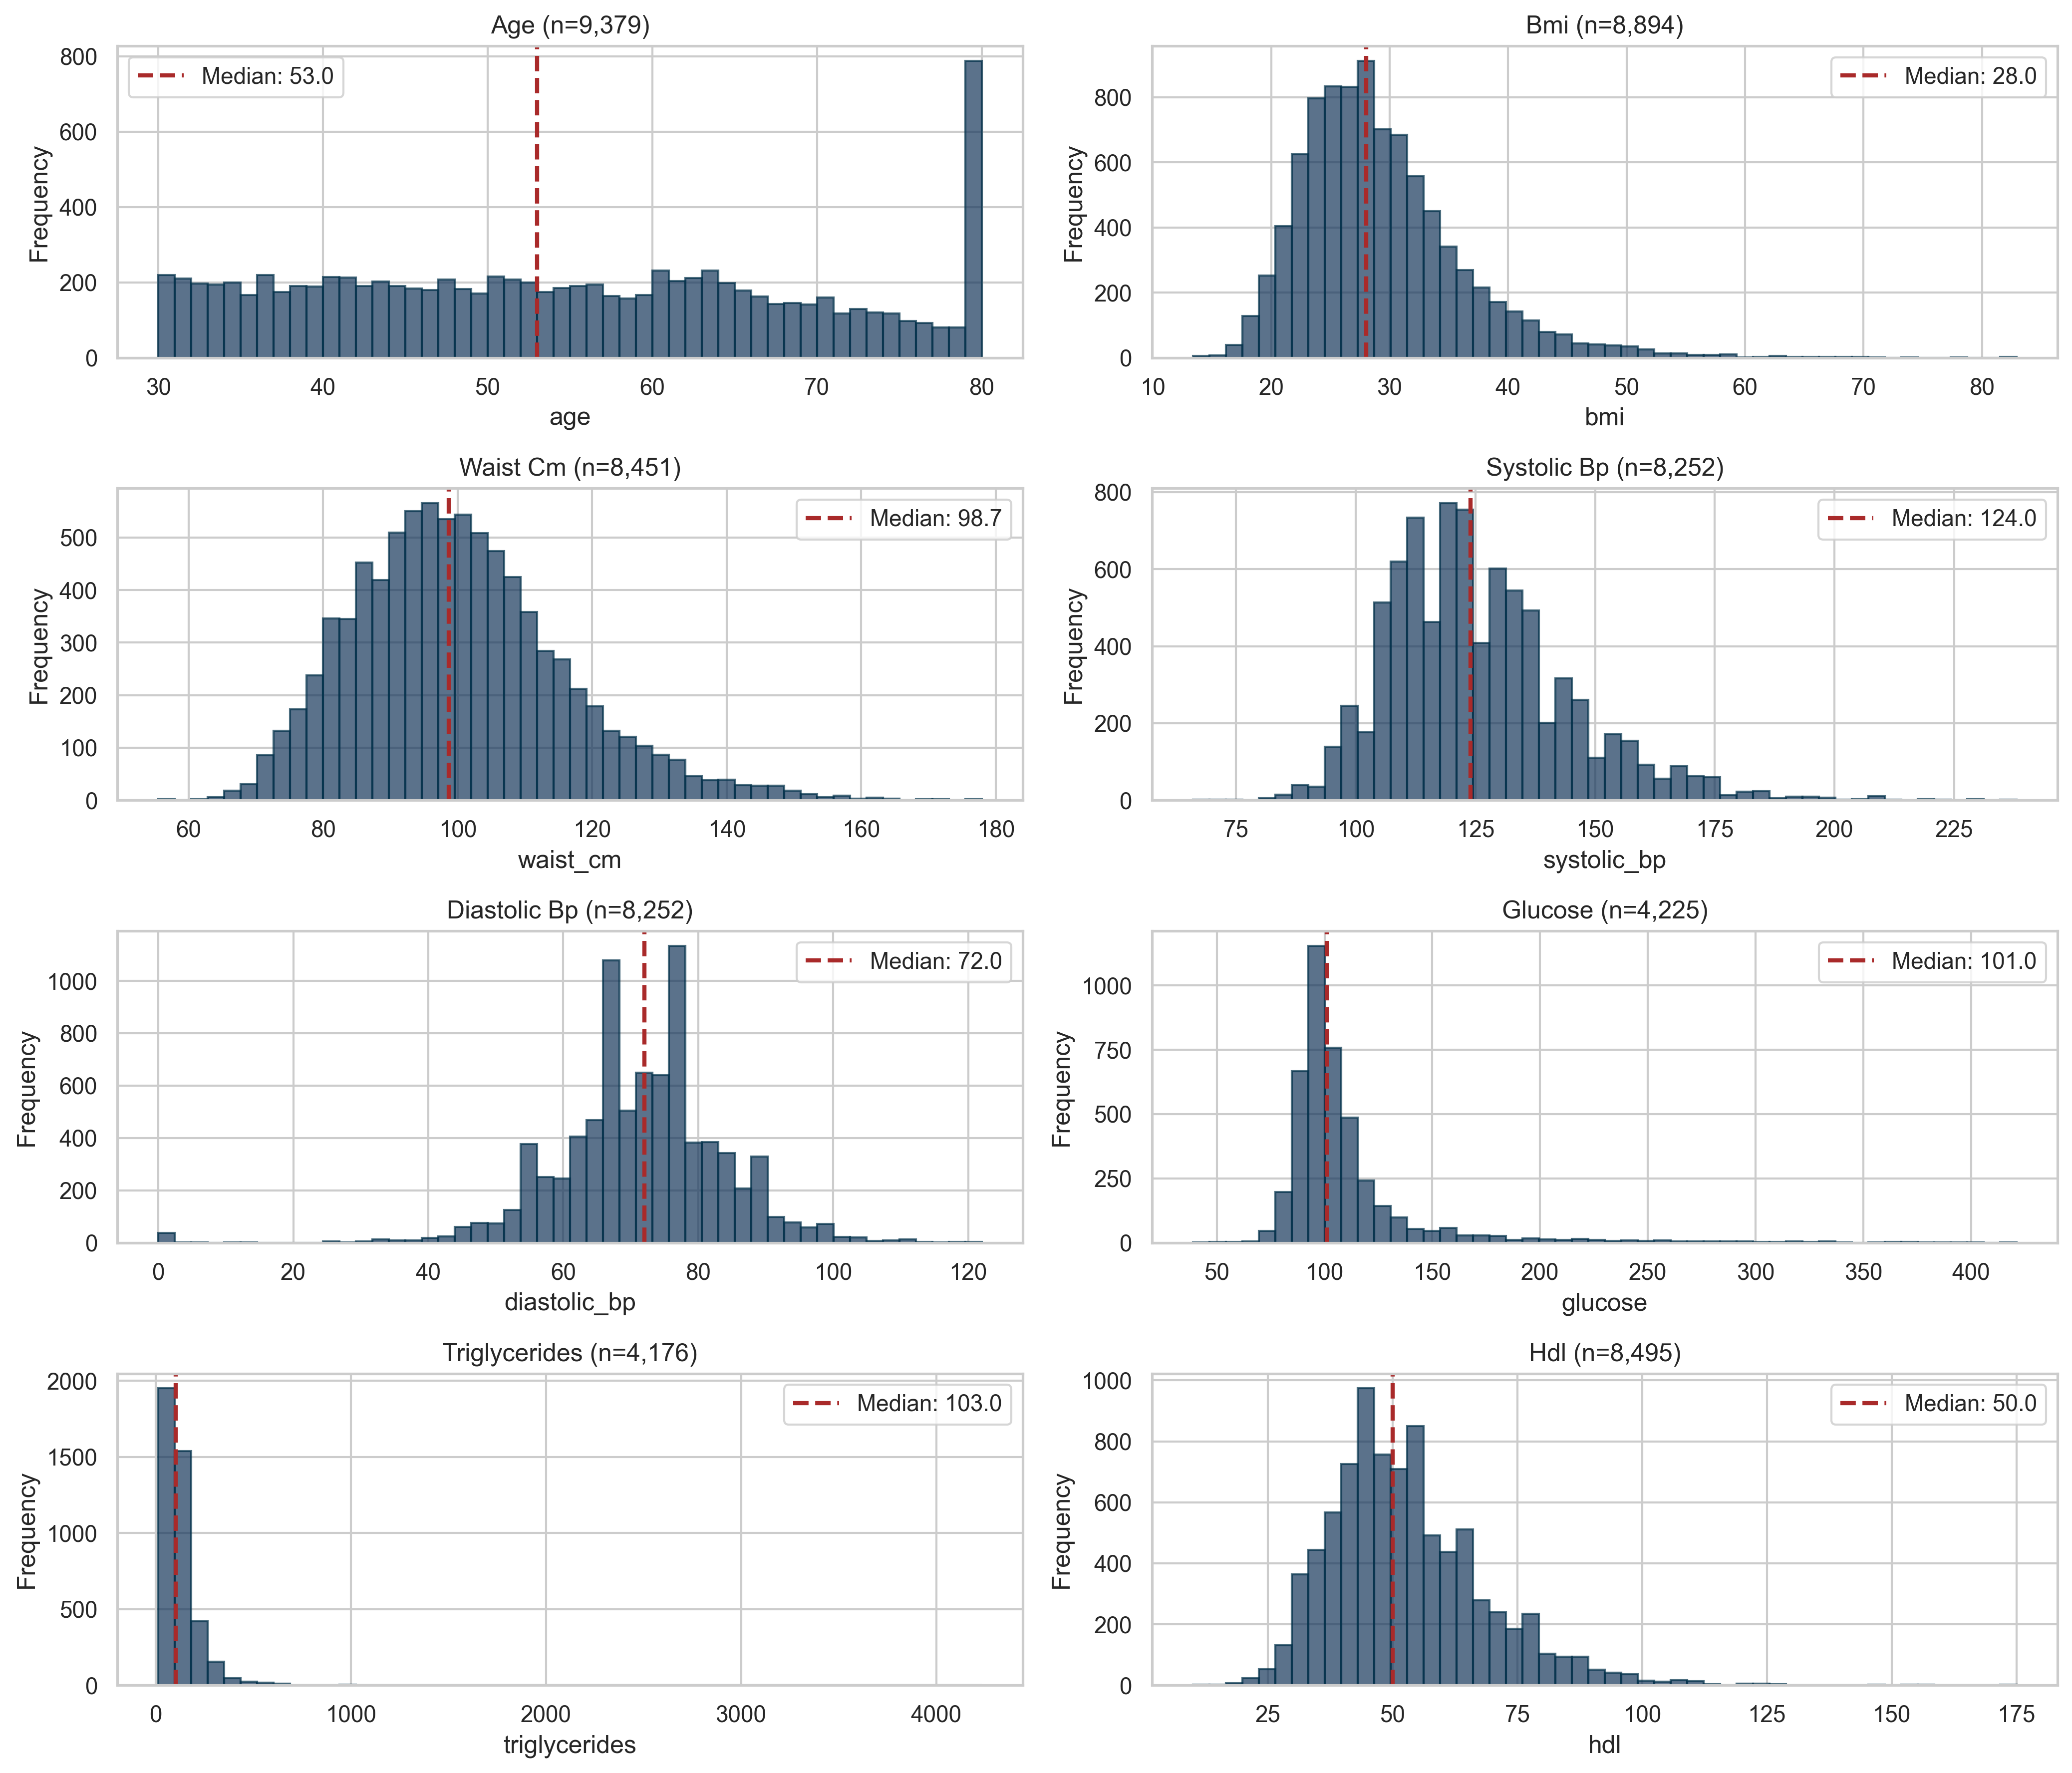

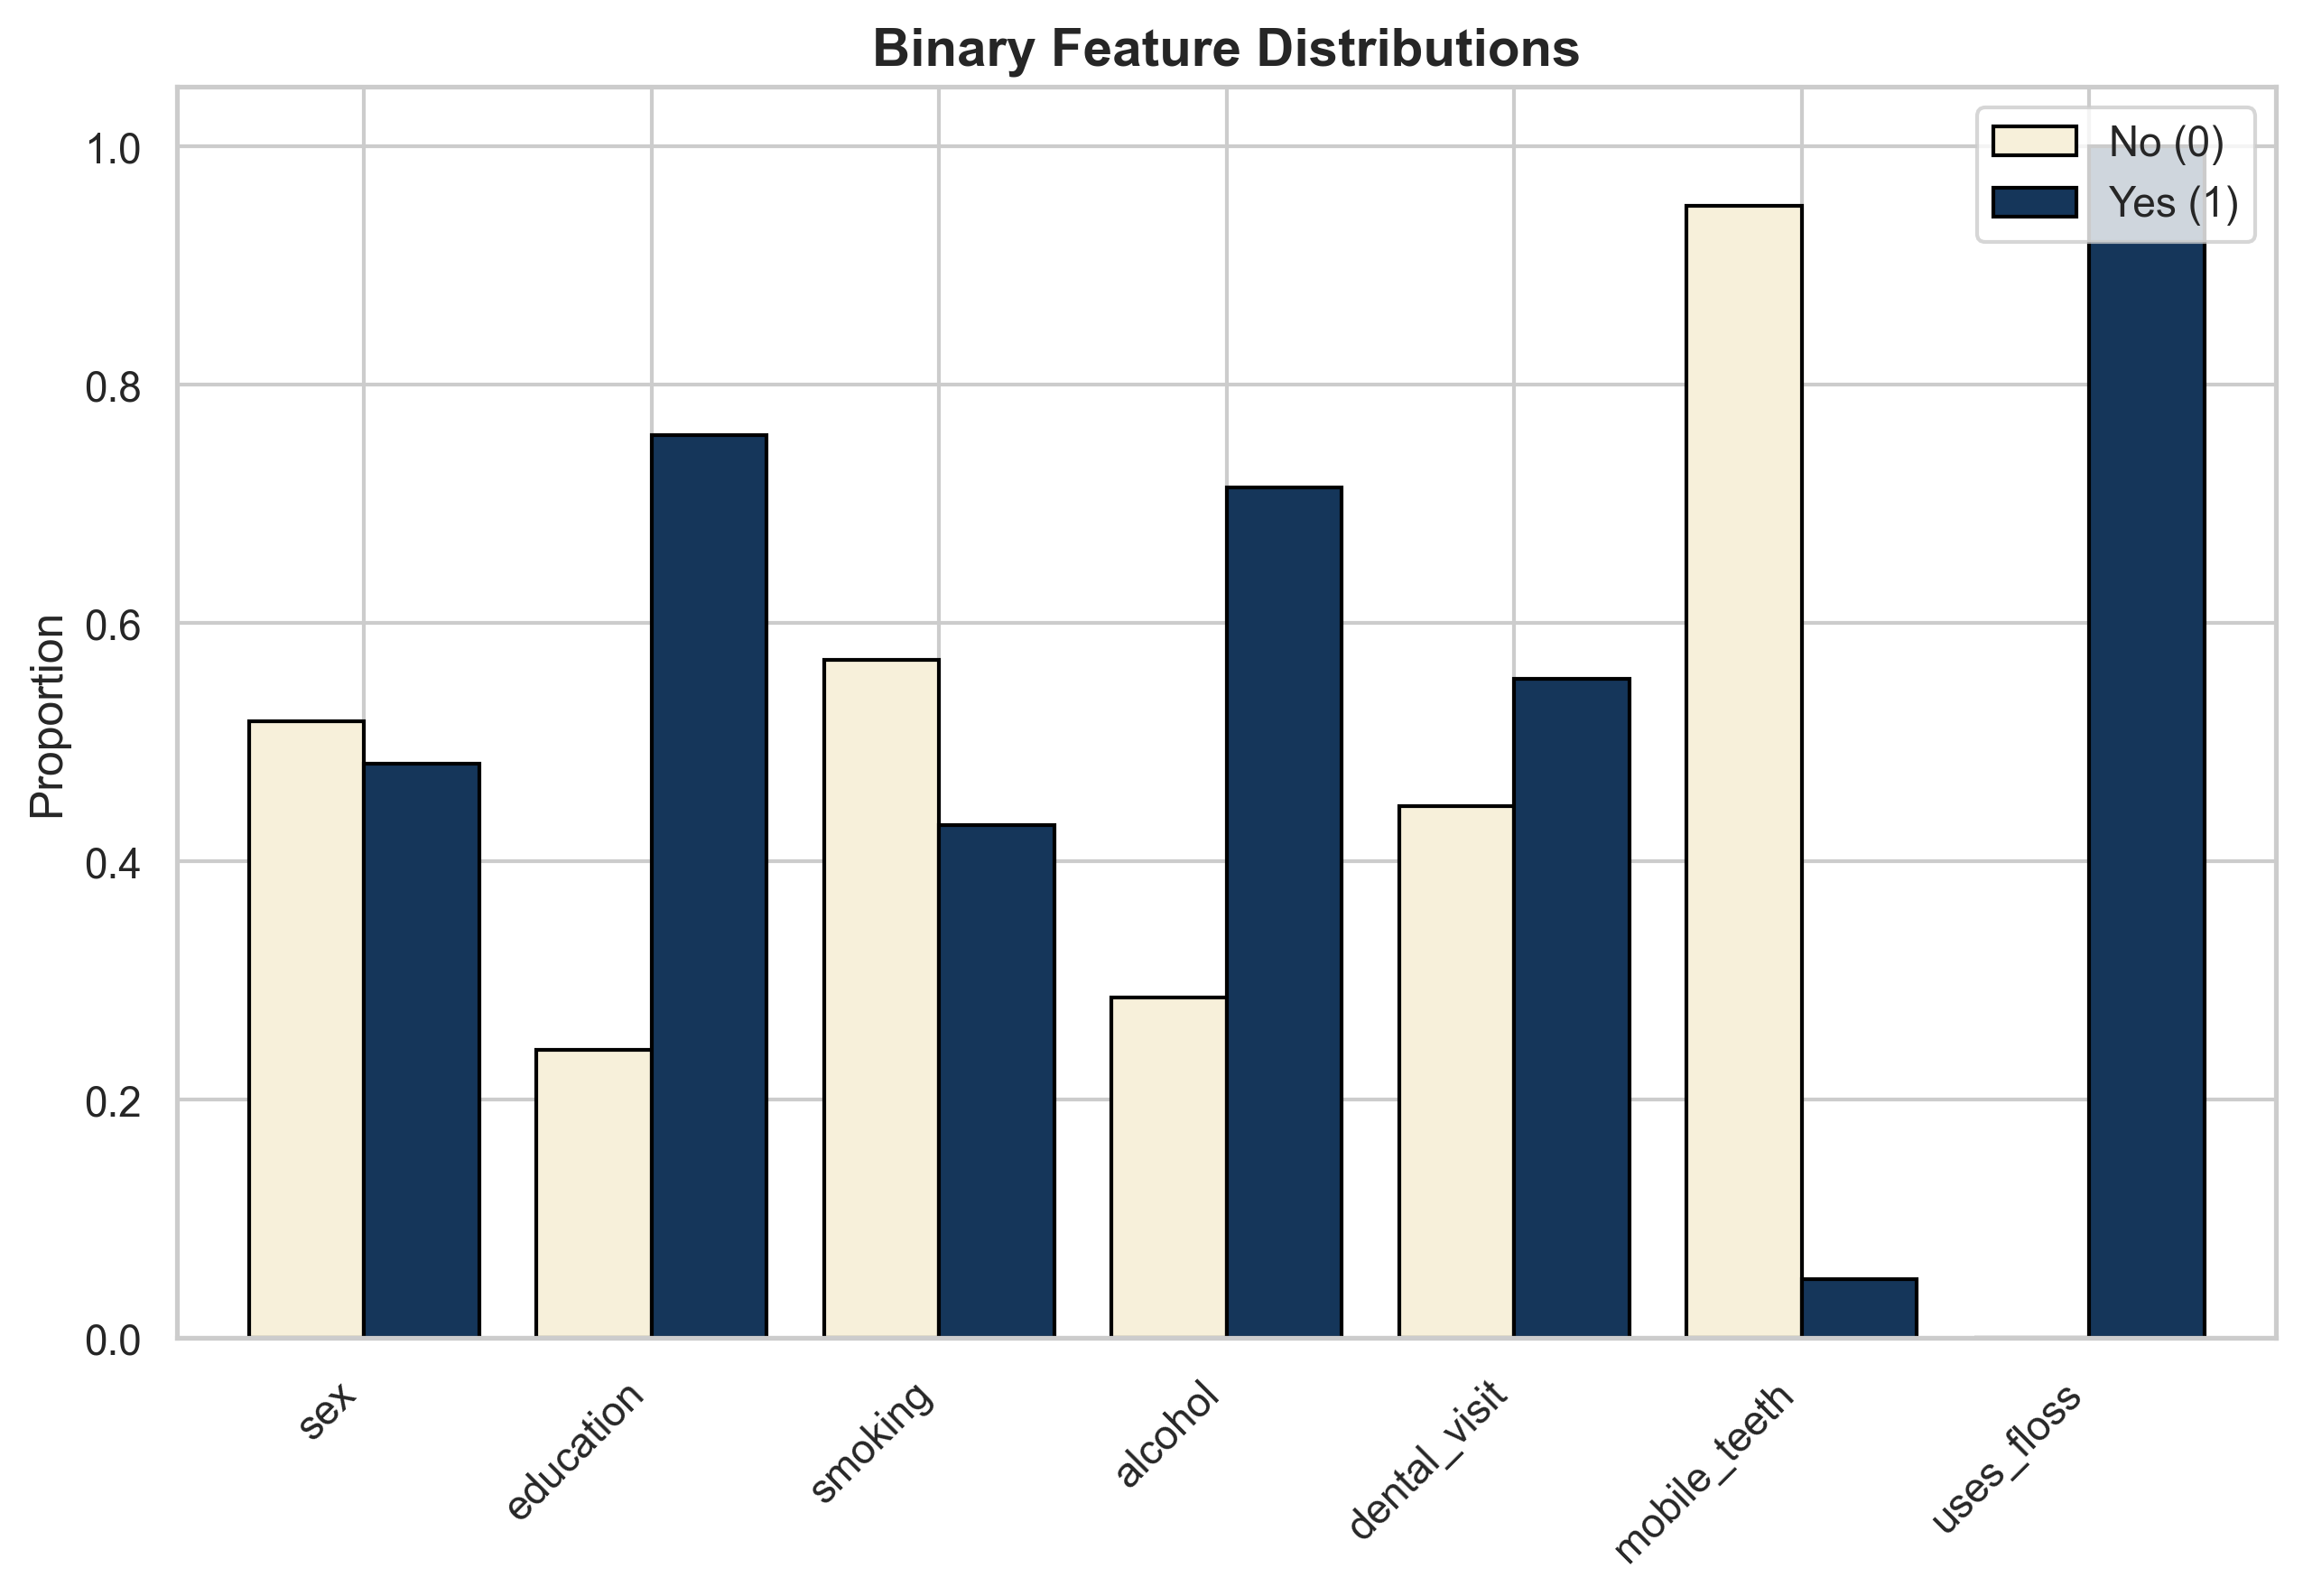

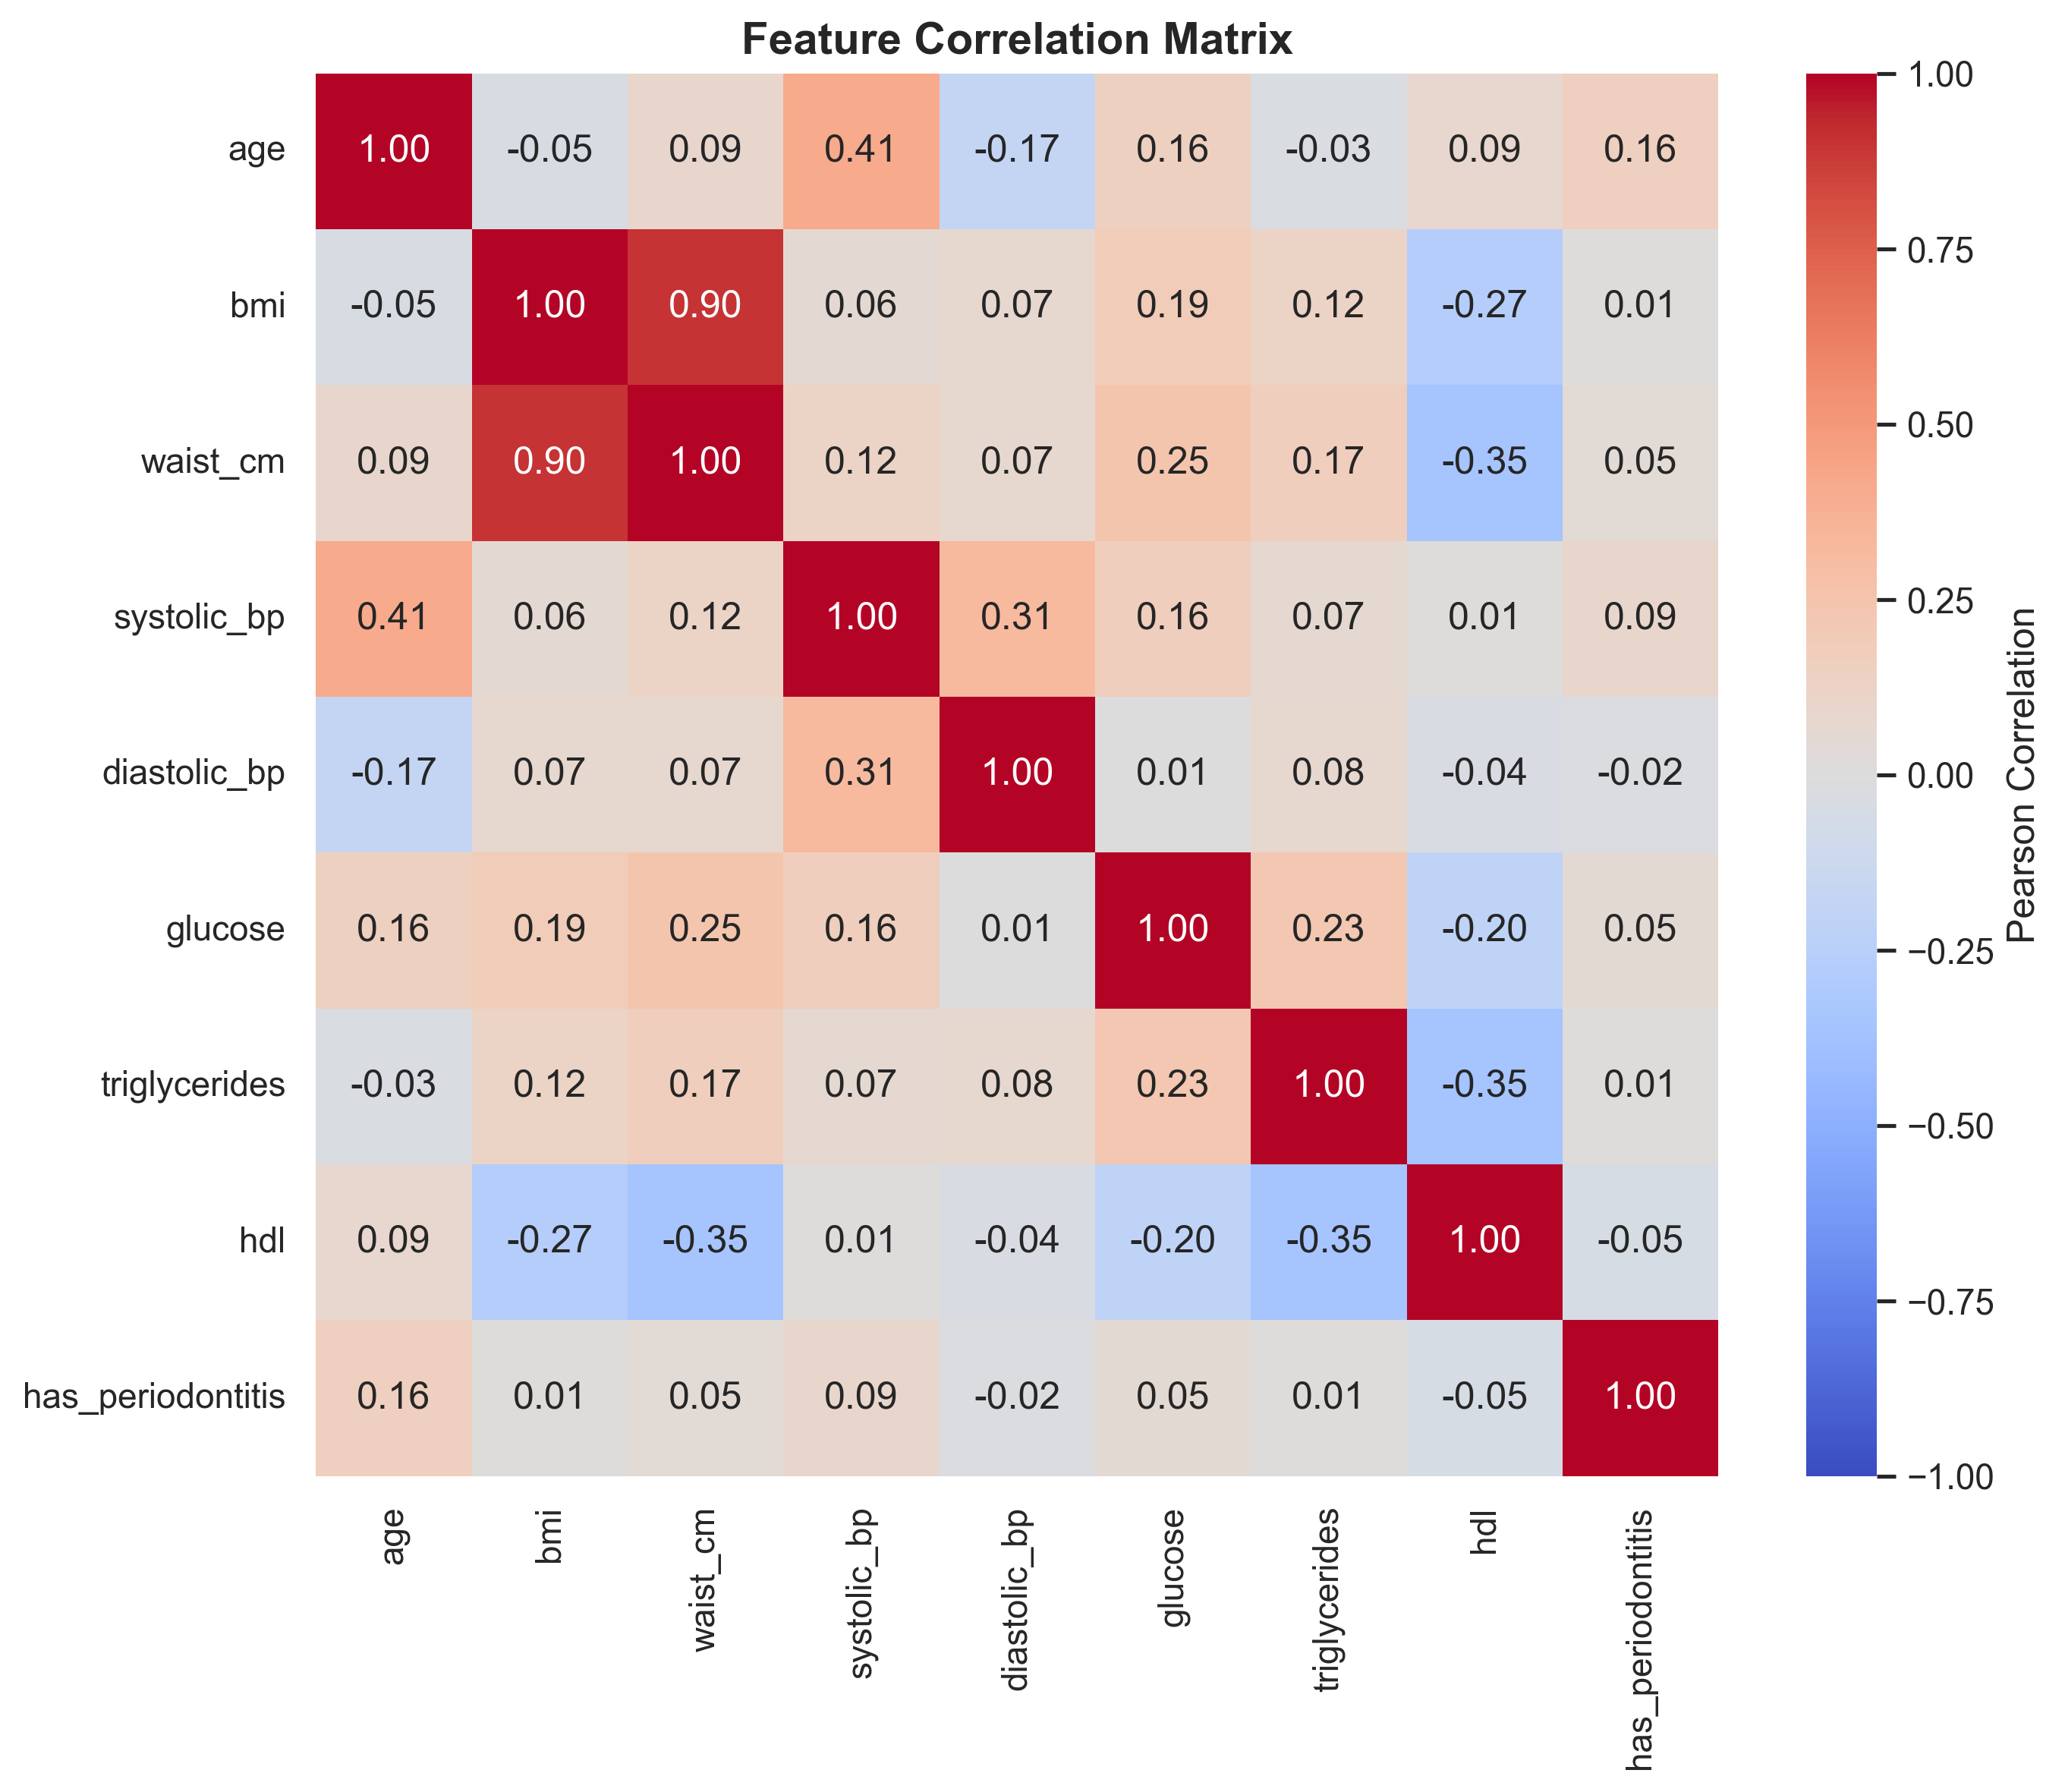

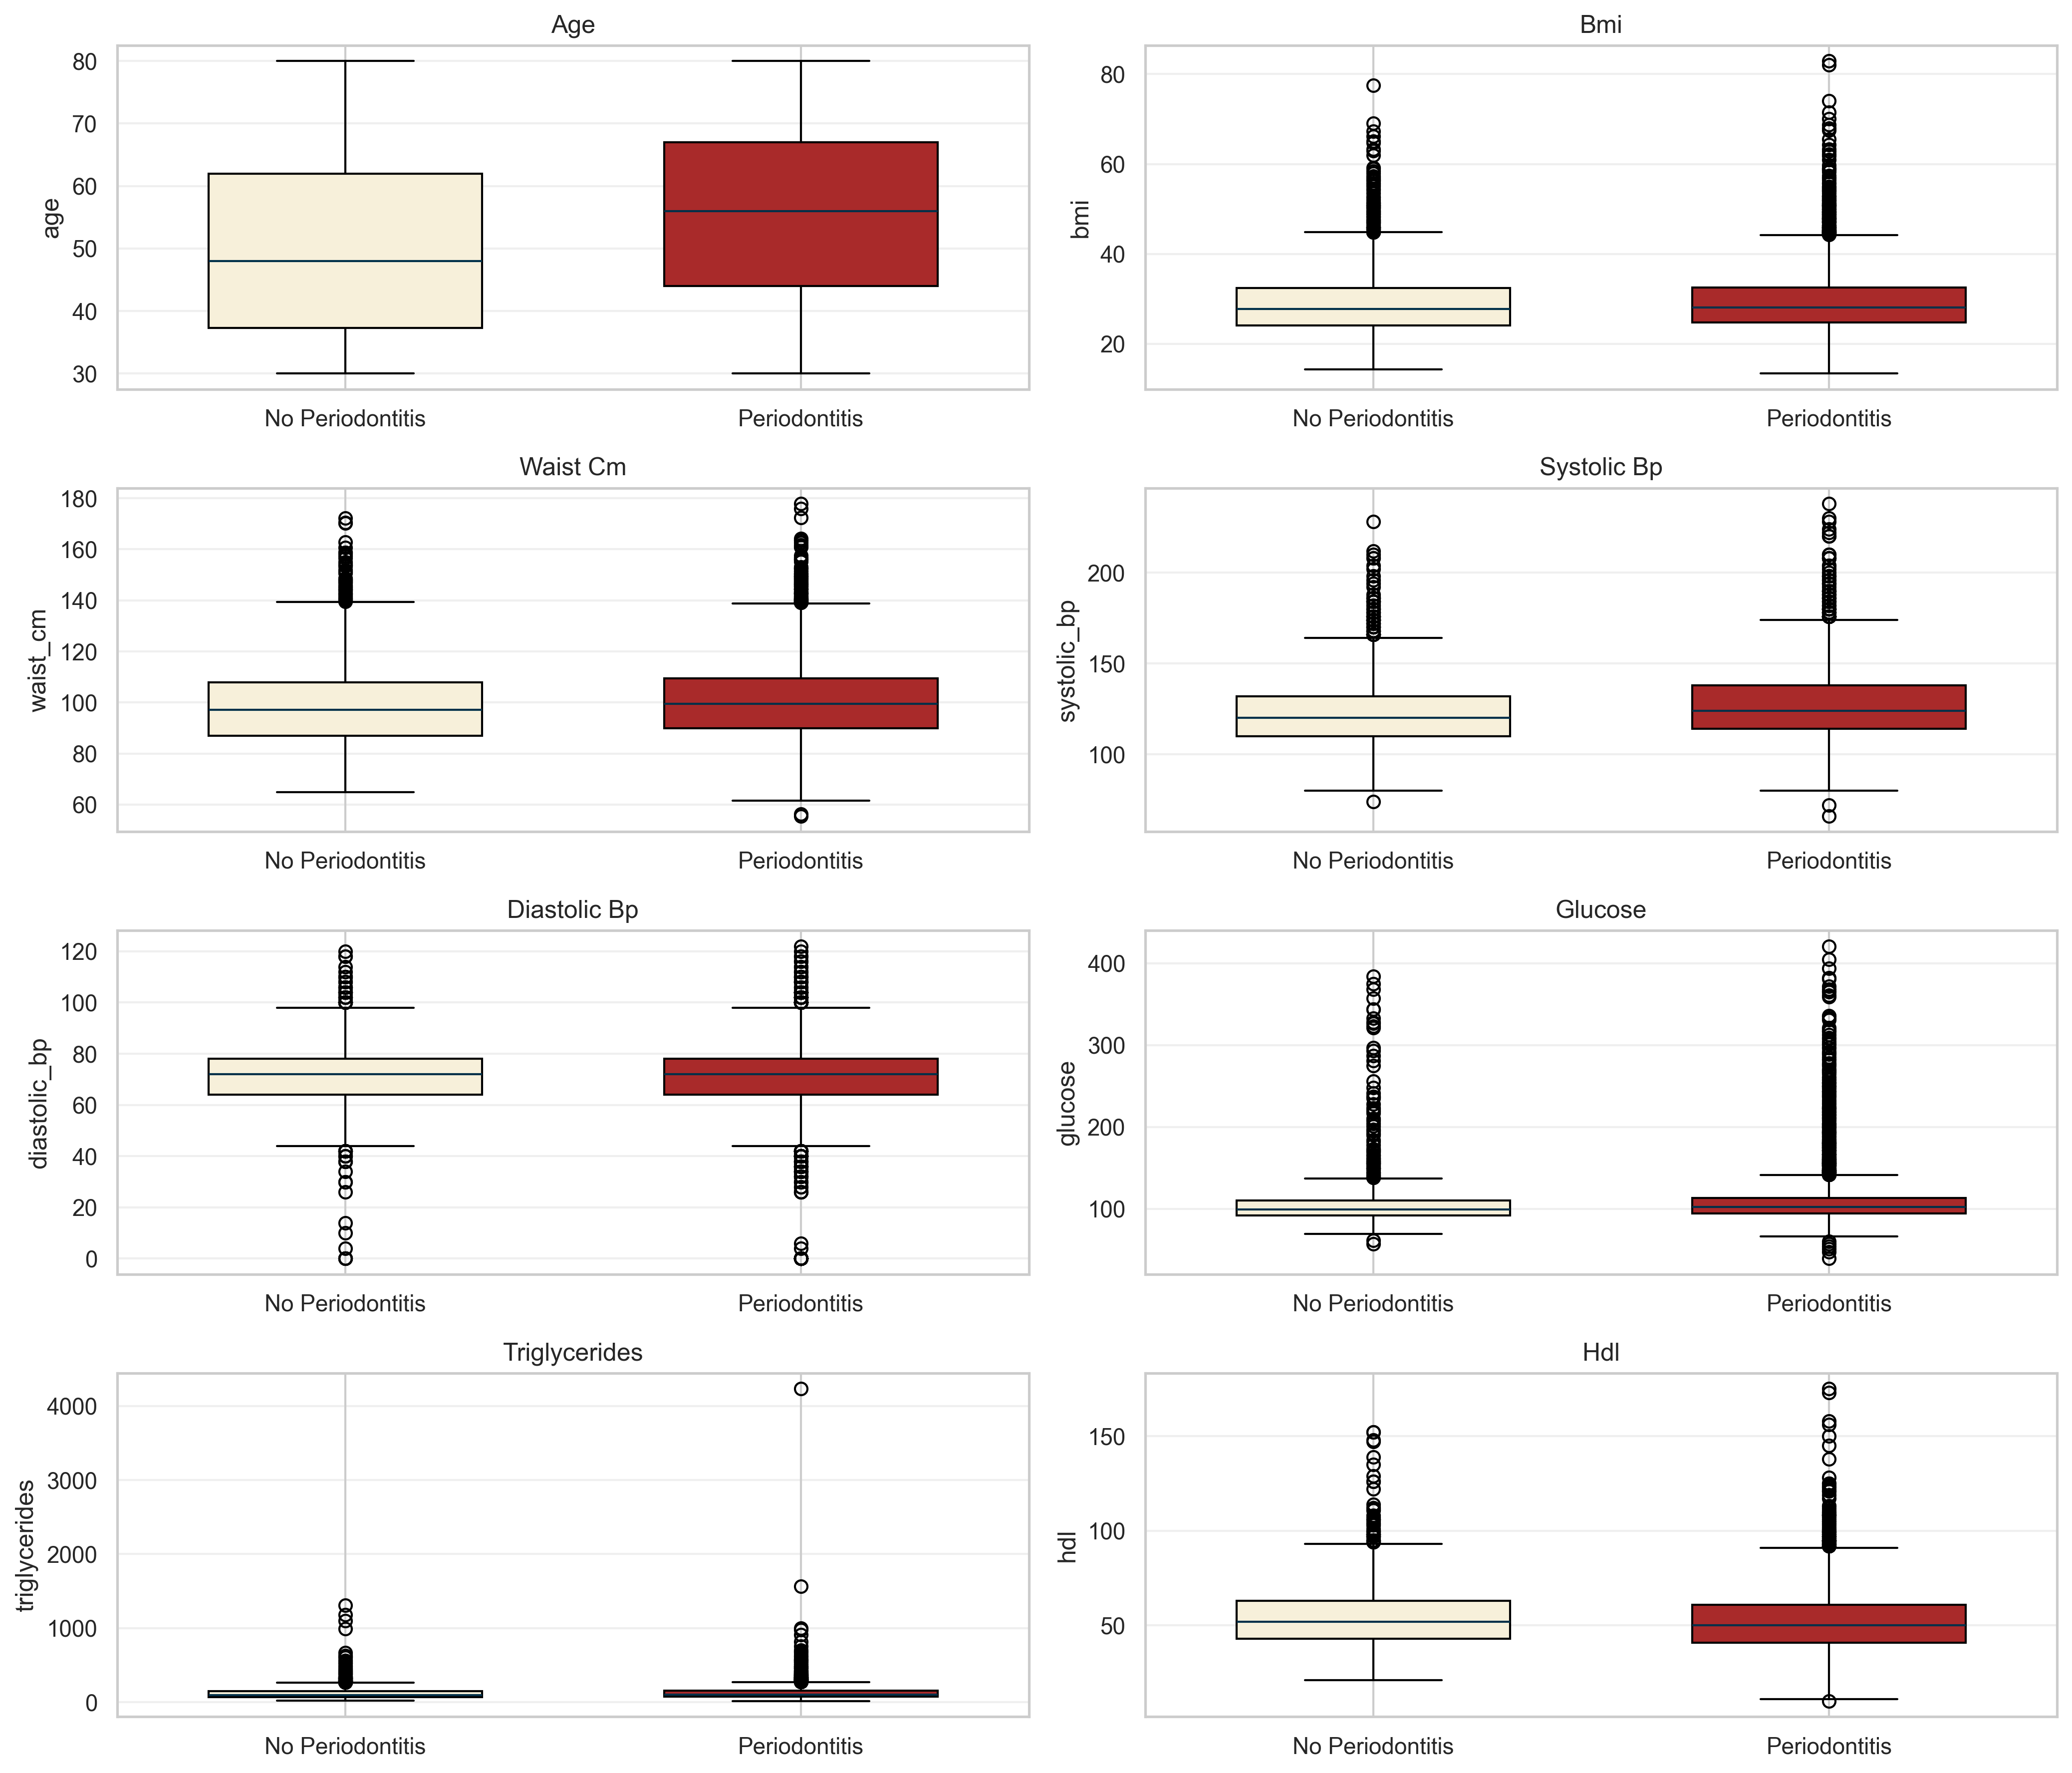

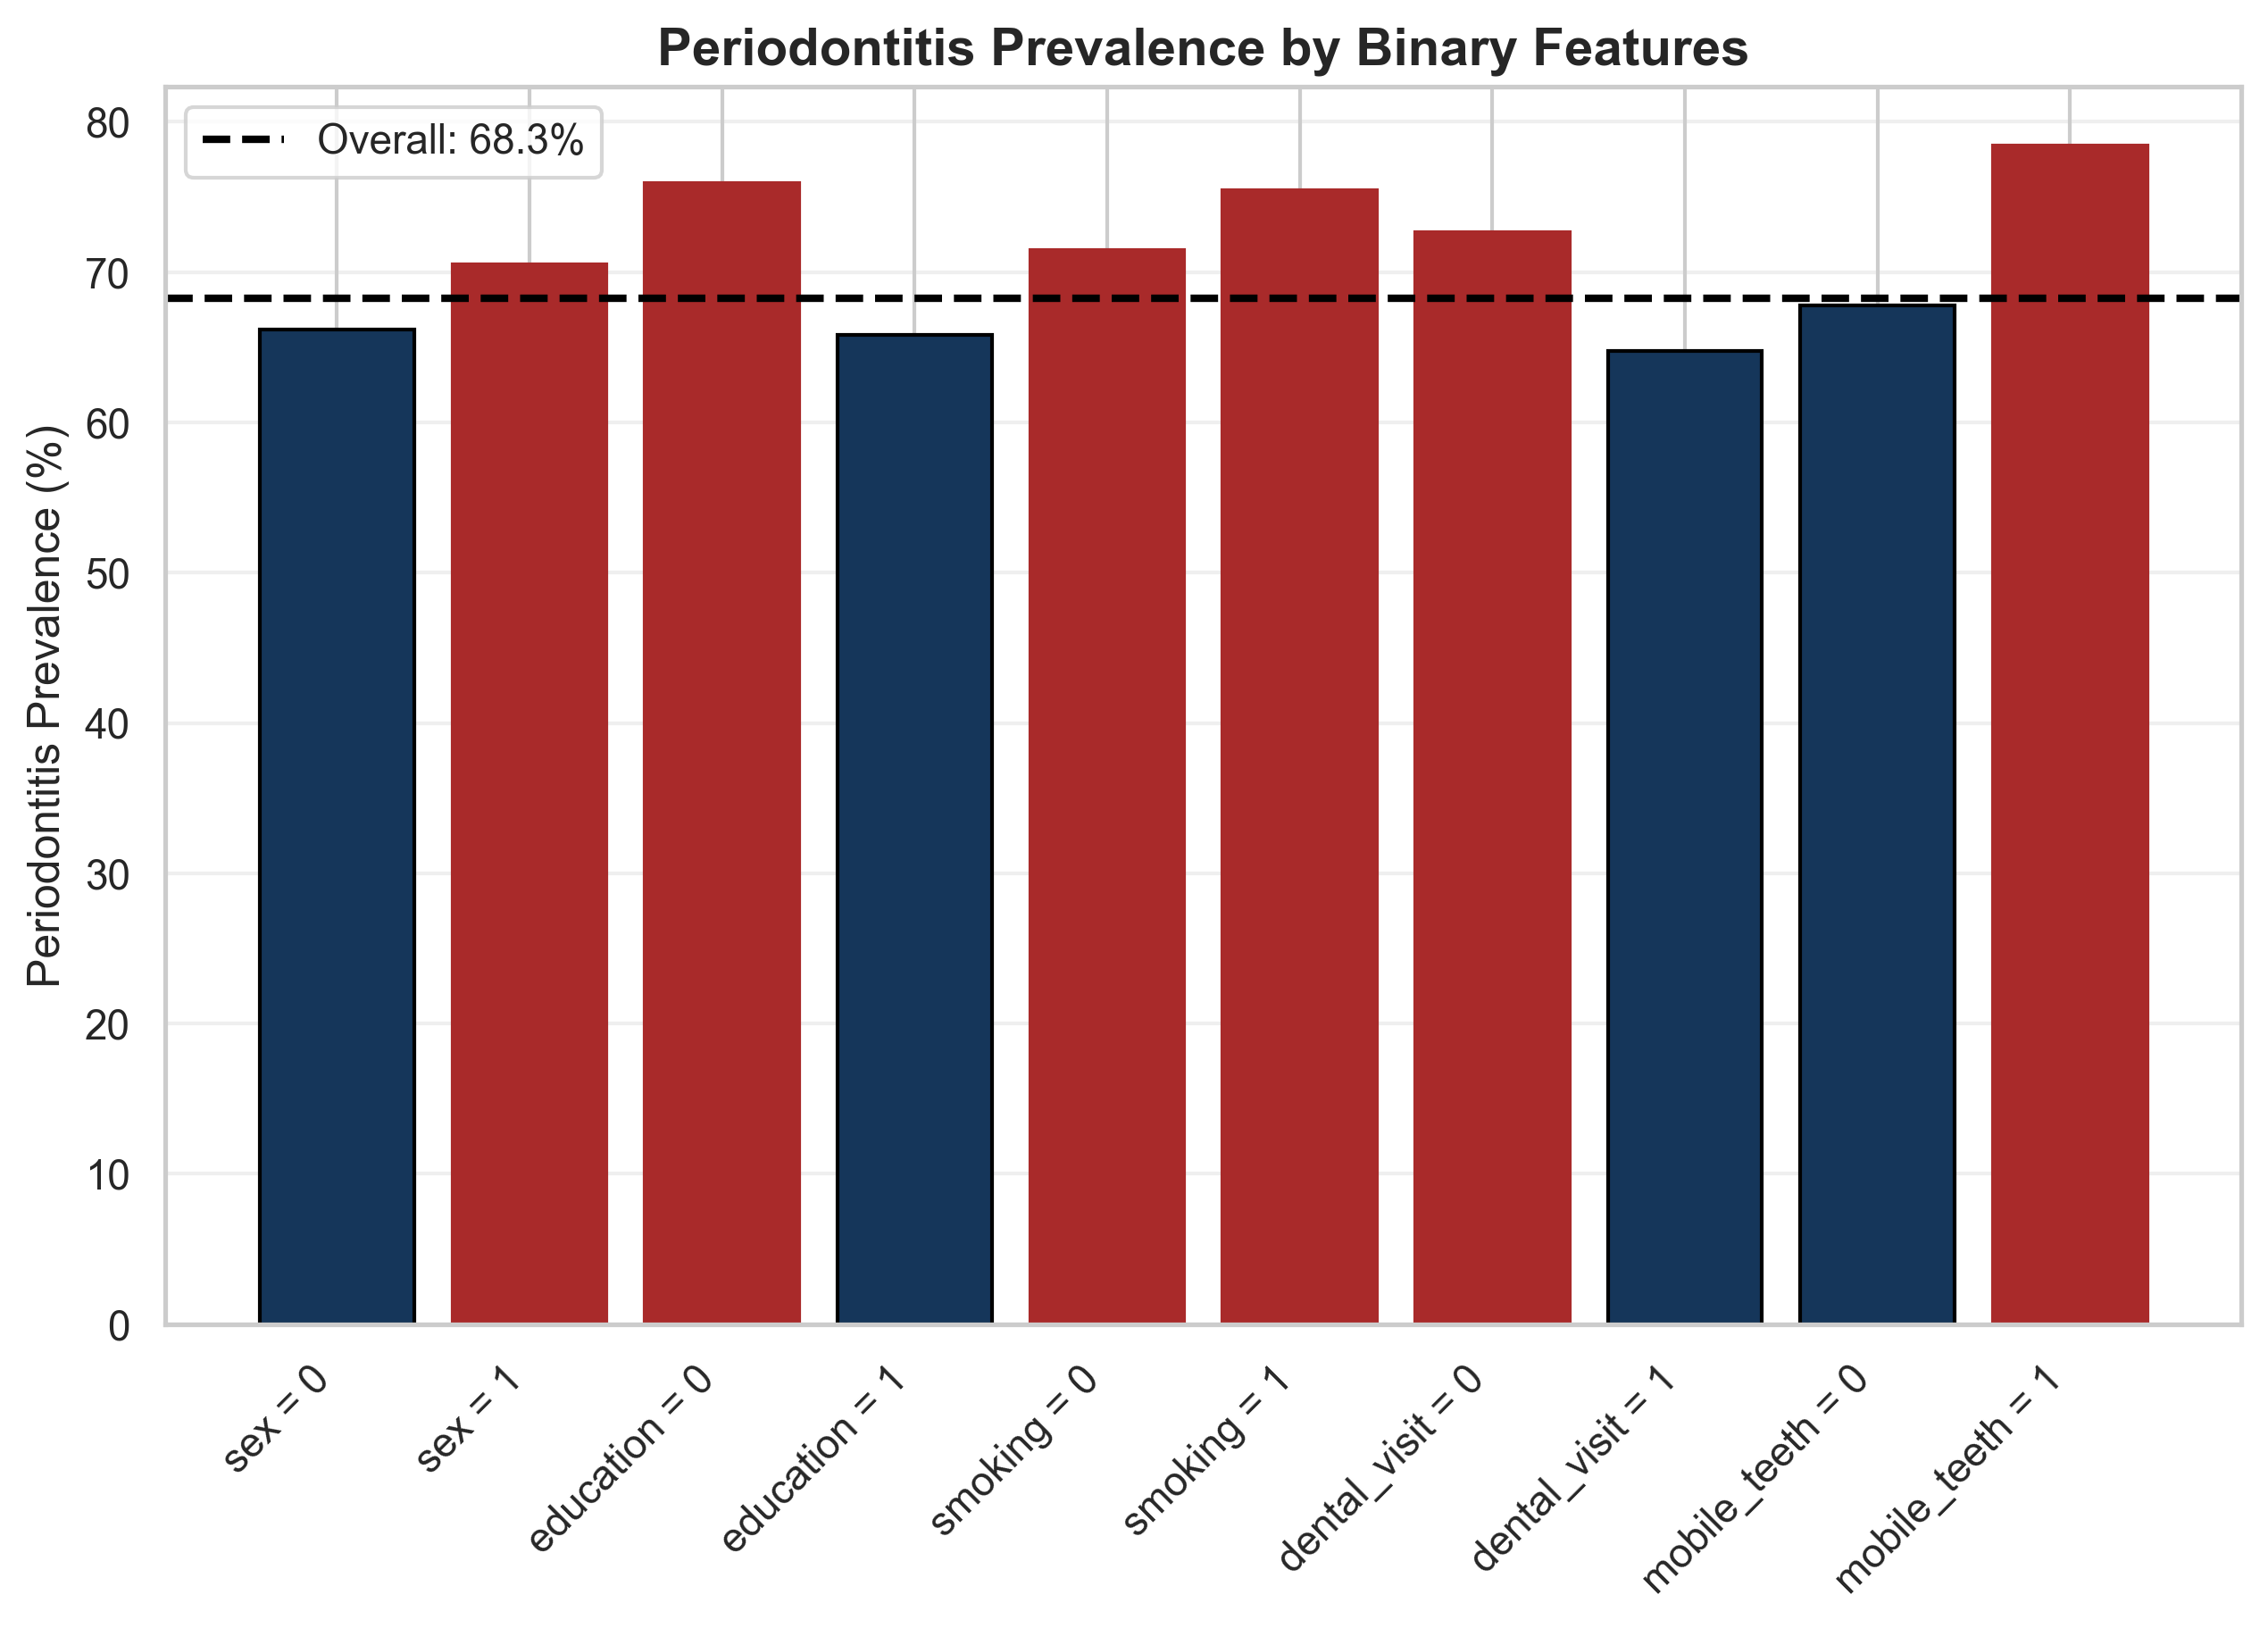

In [23]:
# =============================================================================
# Section 7: Exploratory Data Analysis
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# 1. Missing Data Heatmap
# -------------------------
print("📊 Generating Missing Data Heatmap...")
fig, ax = plt.subplots(figsize=(12, 6))
msno.matrix(df_features, ax=ax, color=PERIOSPOT_BLUE_RGB)  # ✅ RGB version!
plt.title("Missing Data Pattern Across 15 Predictors", fontsize=14, fontweight='bold')
save_figure(fig, FIGURES_DIR / '02_missing_data_matrix.png')

# 2. Continuous Feature Distributions
# -------------------------------------
print("\n📊 Generating Continuous Feature Distributions...")
continuous_vars = ['age', 'bmi', 'waist_cm', 'systolic_bp', 'diastolic_bp', 
                   'glucose', 'triglycerides', 'hdl']

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for idx, var in enumerate(continuous_vars):
    ax = axes.flatten()[idx]
    data = df_features[var].dropna()
    
    # Histogram with Periospot colors
    data.hist(bins=50, ax=ax, 
              color=PERIOSPOT_BLUE,  # ✅ Hex works for matplotlib
              edgecolor=MYSTIC_BLUE, 
              alpha=0.7)
    
    # Add median line
    median_val = data.median()
    ax.axvline(median_val, 
               color=CRIMSON_BLAZE, 
               linestyle='--', 
               linewidth=2,
               label=f'Median: {median_val:.1f}')
    
    ax.set_title(f"{var.replace('_', ' ').title()} (n={len(data):,})")
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '03_continuous_distributions.png')

# 3. Binary Feature Frequencies
# -------------------------------
print("\n📊 Generating Binary Feature Frequencies...")
binary_vars = ['sex', 'education', 'smoking', 'alcohol', 
               'dental_visit', 'mobile_teeth', 'uses_floss']

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate frequencies
freq_data = []
for var in binary_vars:
    counts = df_features[var].value_counts(normalize=True, dropna=True)
    freq_data.append({
        'variable': var,
        'no': counts.get(0, 0),
        'yes': counts.get(1, 0)
    })

freq_df = pd.DataFrame(freq_data).set_index('variable')

# Plot
freq_df.plot(kind='bar', ax=ax, 
             color=[VANILLA_CREAM, PERIOSPOT_BLUE], 
             edgecolor=BLACK, 
             width=0.8)

ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Binary Feature Distributions', fontsize=14, fontweight='bold')
ax.legend(['No (0)', 'Yes (1)'], loc='upper right')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')

save_figure(fig, FIGURES_DIR / '04_binary_distributions.png')

# 4. Correlation Matrix
# -----------------------
print("\n📊 Generating Correlation Matrix...")
numeric_features = ['age', 'bmi', 'waist_cm', 'systolic_bp', 'diastolic_bp',
                    'glucose', 'triglycerides', 'hdl', 'has_periodontitis']

corr_matrix = df_features[numeric_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax, square=True,
            cbar_kws={'label': 'Pearson Correlation'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

save_figure(fig, FIGURES_DIR / '05_correlation_matrix.png')

# 5. Features vs Target (Continuous)
# ------------------------------------
print("\n📊 Generating Features vs Target (Continuous)...")
continuous_vars = ['age', 'bmi', 'waist_cm', 'systolic_bp', 'diastolic_bp',
                   'glucose', 'triglycerides', 'hdl']

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for idx, var in enumerate(continuous_vars):
    ax = axes.flatten()[idx]
    
    # Create separate data for each group
    no_perio = df_features[df_features['has_periodontitis'] == 0][var].dropna()
    yes_perio = df_features[df_features['has_periodontitis'] == 1][var].dropna()
    
    # Boxplot
    bp = ax.boxplot([no_perio, yes_perio], 
                     labels=['No Periodontitis', 'Periodontitis'],
                     patch_artist=True,
                     widths=0.6)
    
    # Color boxes
    bp['boxes'][0].set_facecolor(VANILLA_CREAM)
    bp['boxes'][0].set_edgecolor(BLACK)
    bp['boxes'][1].set_facecolor(CRIMSON_BLAZE)
    bp['boxes'][1].set_edgecolor(BLACK)
    
    ax.set_title(f"{var.replace('_', ' ').title()}")
    ax.set_ylabel(var)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '06_features_vs_target_continuous.png')

# 6. Features vs Target (Binary)
# --------------------------------
print("\n📊 Generating Features vs Target (Binary)...")
binary_vars = ['sex', 'education', 'smoking', 'dental_visit', 'mobile_teeth']

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate periodontitis prevalence by feature value
prevalence_data = []
for var in binary_vars:
    for val in [0, 1]:
        subset = df_features[df_features[var] == val]
        if len(subset) > 0:
            prev = subset['has_periodontitis'].mean()
            prevalence_data.append({
                'feature': f"{var} = {val}",
                'prevalence': prev * 100
            })

prev_df = pd.DataFrame(prevalence_data)

# Plot
bars = ax.bar(range(len(prev_df)), prev_df['prevalence'], 
              color=PERIOSPOT_BLUE, edgecolor=BLACK, width=0.8)

# Highlight bars above overall prevalence
overall_prev = df_features['has_periodontitis'].mean() * 100
for i, bar in enumerate(bars):
    if prev_df.iloc[i]['prevalence'] > overall_prev:
        bar.set_color(CRIMSON_BLAZE)

ax.axhline(overall_prev, color=BLACK, linestyle='--', 
           linewidth=2, label=f'Overall: {overall_prev:.1f}%')

ax.set_ylabel('Periodontitis Prevalence (%)', fontsize=12)
ax.set_title('Periodontitis Prevalence by Binary Features', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(prev_df)))
ax.set_xticklabels(prev_df['feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

save_figure(fig, FIGURES_DIR / '07_features_vs_target_binary.png')

print("\n" + "="*60)
print("✅ Section 7: Exploratory Data Analysis Complete")
print(f"   Generated 6 visualizations in {FIGURES_DIR}")
print("="*60)

## 8️⃣ Stratified Cross-Validation Setup

**Method:** 5-fold stratified K-fold

**Stratify by:** `has_periodontitis` (maintains 68% prevalence in each fold)

**Random state:** 42 (reproducibility)

---

---

## Section 7.5: Data Cleaning & Outlier Treatment

Based on EDA findings, apply data cleaning:
- **Diastolic BP:** Winsorize outliers to physiological range [40, 120] mmHg
- **Triglycerides:** Winsorize extreme outliers at 99th percentile
- **Waist circumference:** Remove (r=0.90 with BMI, redundant)
- **Feature count:** 15 → 14 predictors


In [ ]:
print("="*80)
print("🧹 DATA CLEANING & OUTLIER TREATMENT")
print("="*80)

# Load features
df_features = pd.read_parquet(PROCESSED_DIR / 'features_full.parquet')
df_cleaned = df_features.copy()

print(f"\n📊 Before cleaning: {df_cleaned.shape}")

# 1. Fix diastolic BP outliers
print("\n1️⃣ Diastolic BP Outlier Treatment:")
outliers_bp = ((df_cleaned['diastolic_bp'] < 40) | (df_cleaned['diastolic_bp'] > 120)).sum()
print(f"   Found {outliers_bp} outliers (<40 or >120 mmHg)")
print(f"   Min before: {df_cleaned['diastolic_bp'].min():.2f}, Max before: {df_cleaned['diastolic_bp'].max():.2f}")
df_cleaned['diastolic_bp'] = df_cleaned['diastolic_bp'].clip(lower=40, upper=120)
print(f"   Min after:  {df_cleaned['diastolic_bp'].min():.2f}, Max after:  {df_cleaned['diastolic_bp'].max():.2f}")
print(f"   ✅ Winsorized to [40, 120] mmHg")

# 2. Fix triglycerides outliers
print("\n2️⃣ Triglycerides Outlier Treatment:")
q99_trig = df_cleaned['triglycerides'].quantile(0.99)
outliers_trig = (df_cleaned['triglycerides'] > q99_trig).sum()
print(f"   99th percentile: {q99_trig:.0f} mg/dL")
print(f"   Found {outliers_trig} outliers (>{q99_trig:.0f} mg/dL)")
print(f"   Max before: {df_cleaned['triglycerides'].max():.0f} mg/dL")
df_cleaned['triglycerides'] = df_cleaned['triglycerides'].clip(upper=q99_trig)
print(f"   Max after:  {df_cleaned['triglycerides'].max():.0f} mg/dL")
print(f"   ✅ Winsorized to [0, {q99_trig:.0f}] mg/dL")

# 3. Remove waist_cm (multicollinear with BMI)
print("\n3️⃣ Remove Multicollinear Features:")
print(f"   Correlation: BMI ↔ Waist = {df_cleaned[['bmi', 'waist_cm']].corr().iloc[0,1]:.3f}")
df_cleaned = df_cleaned.drop(columns=['waist_cm'])
print(f"   ✅ Removed waist_cm (redundant with BMI)")

# 4. Summary
print("\n📊 After cleaning:")
print(f"   Shape: {df_cleaned.shape}")
print(f"   Features: {len(df_cleaned.columns) - 4} predictors")
print(f"   - Demographics: age, sex, education")
print(f"   - Behaviors: smoking, alcohol")
print(f"   - Metabolic: bmi, systolic_bp, diastolic_bp, glucose, triglycerides, hdl")
print(f"   - Oral Health: dental_visit, mobile_teeth, floss_days")

# 5. Save cleaned dataset
df_cleaned.to_parquet(PROCESSED_DIR / 'features_cleaned.parquet')
print(f"\n✅ Saved: {PROCESSED_DIR / 'features_cleaned.parquet'}")

print("\n" + "="*80)
print("✅ Section 7.5: Data cleaning complete")
print("="*80)


In [ ]:
# Setup stratified K-fold cross-validation
from sklearn.model_selection import StratifiedKFold

# Pool both cycles into single dataset
df_2011 = pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet')
df_2013 = pd.read_parquet(PROCESSED_DIR / '2013_2014_labeled.parquet')
df_full = pd.concat([df_2011, df_2013], axis=0, ignore_index=True)

print(f"📊 Combined Dataset:")
print(f"   Total participants: {len(df_full):,}")
print(f"   Periodontitis prevalence: {df_full['has_periodontitis'].mean():.2%}")
print(f"   Shape: {df_full.shape}")

# Initialize stratified K-fold
skf = StratifiedKFold(
    n_splits=config['validation_strategy']['n_folds'],
    shuffle=config['validation_strategy']['shuffle'],
    random_state=config['validation_strategy']['random_state']
)

# Verify stratification works
y = df_full['has_periodontitis']
print(f"\n📋 Cross-Validation Folds:")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_full, y), 1):
    train_prevalence = y.iloc[train_idx].mean()
    val_prevalence = y.iloc[val_idx].mean()
    print(f"   Fold {fold_idx}: Train={len(train_idx):,} ({train_prevalence:.1%}), "
          f"Val={len(val_idx):,} ({val_prevalence:.1%})")

print("\n✅ Section 8: Stratified 5-fold CV setup complete")

## 9️⃣ Preprocessing Pipelines

**Build:** Sklearn pipelines with imputation + scaling

**Strategy:** Fit on each CV training fold separately (prevent data leakage)

**Note:** Tree-based models (XGBoost/CatBoost/LightGBM) don't require scaling

---

In [ ]:
# TODO: Build sklearn pipelines
print("✅ Section 9: Pipelines built")

## 🔟 Baseline Models

LogReg, RandomForest with 5-fold CV

---

In [ ]:
# TODO: Train baselines
print("✅ Section 10: Baselines trained")

## 1️⃣1️⃣ XGBoost + Optuna

Hyperparameter search, early stopping

---

In [ ]:
# TODO: Optuna tune XGBoost
print("✅ Section 11: XGBoost tuned")

## 1️⃣2️⃣ CatBoost + Optuna

Native categorical handling

---

In [ ]:
# TODO: Optuna tune CatBoost
print("✅ Section 12: CatBoost tuned")

## 1️⃣3️⃣ LightGBM + Optuna

Fast gradient boosting

---

In [ ]:
# TODO: Optuna tune LightGBM
print("✅ Section 13: LightGBM tuned")

## 1️⃣4️⃣ Model Comparison & Statistical Testing

**Compare:** All models across 5 CV folds

**Metrics:** Mean AUC-ROC, PR-AUC, F1-score with 95% CI

**Statistical tests:** Paired t-test for significance

---

In [ ]:
# TODO: Compare models and compute statistical significance
# Compare mean AUC-ROC, PR-AUC, F1 across folds
# Perform paired t-tests between XGBoost/CatBoost/LightGBM and baselines
# Create comparison table and box plots
print("✅ Section 14: Model comparison complete")

## 1️⃣5️⃣ Calibration Analysis

**Evaluate:** Probability calibration using reliability diagrams

**Methods:** Isotonic regression and Platt scaling

**Plot:** Calibration curves for best models

---

In [ ]:
# TODO: Calibration analysis
# Plot calibration curves for best models
# Apply isotonic regression  
# Compute Brier scores before/after calibration
print("✅ Section 15: Calibration analysis complete")

## 1️⃣6️⃣ SHAP Feature Importance

**Interpretability:** Explain model predictions using SHAP values

**Plots:** Beeswarm plot, bar plot, waterfall for individual predictions

**Clinical insight:** Which risk factors matter most?

---

In [ ]:
# TODO: Calibration plots
print("✅ Section 16: Calibration done")

## 1️⃣7️⃣ Decision Curve Analysis

**Clinical utility:** Net benefit across threshold probabilities

**Compare:** Model vs. treat-all vs. treat-none strategies

**Goal:** Identify clinically useful probability thresholds

---

In [ ]:
# TODO: Decision curve analysis
# Plot net benefit curves
# Compare model vs treat-all vs treat-none
# Identify optimal decision thresholds
print("✅ Section 17: Decision curve analysis complete")

## 1️⃣8️⃣ Final Export & Reproducibility

**Save:**
- Best models (.pkl files)
- Cross-validation results (JSON/CSV)
- SHAP values and plots
- Model cards (Hugging Face format)
- Reproducibility log (package versions, git hash, random seeds)

---

In [ ]:
# TODO: Export all artifacts
# Save best models, CV results, SHAP values
# Generate model cards
# Log package versions and git commit hash
# Create reproducibility.json
print("✅ Section 18: All artifacts saved and documented")

## 1️⃣9️⃣ Save Artifacts

Export model, metrics, HF model card

---

In [ ]:
# TODO: Save all artifacts
print("✅ Section 19: Artifacts saved")

## 2️⃣0️⃣ Reproducibility Log

Package versions, git hash, system info

---

In [ ]:
# TODO: Log system info
print("✅ Section 20: Reproducibility logged")